# Music League Analysis


#### Before running after a while, refresh spotify oAuth token here: https://developer.spotify.com/console/get-audio-features-several-tracks/?ids=7ouMYWpwJ422jRcDASZB7P%2C4VqPOruhp5EdPBeR92t6lQ%2C2takcwOaAZWiXQijPHIx7B

## Ideas

### DONE: 
#### 1. also maybe agreement scoring? similarity in voting behavior between 2 people
#### 2. Melissa- what would happen if you divided the total number of points each person to times given points
#### 3. percent to each other
#### 4. [0s without Comments][0s with comments][Votes without comments][Votes with comments]
#### 5. pull in spotify feature data for every song

### DOING: 
#### 1. Cluster analysis on two factors: what % of songs you give votes to, what % of songs you comment on
####     a.THIS IS MOSTLY DONE, JUST NEED TO FIGURE OUT HOVERING ON GRAPHS 
####     b.count of number of songs submitted by each person = denominator for avg points per round, use that
####     c. with the total points received to make a standardized score for better clustering.  
#### 2. Looking at spotify features and how they track over rounds 

### UP NEXT
#### 1. how often do you place high vs. place low (hard because num copmetitors changes in each round...)
#### 2. points above replacement submission
##### Look at the median submission for each round
##### subtract that from your submission each round
##### sum per voter
##### divide by number of rounds participated in
#### % of your votes that went to the bottom 3 of each round (clout chaser)
#### % of your votes that went to the top 3 of each round (good samaritans)

### EH:
#### sort by created date
#### who gets points from the same people

### NOT DOING: 
#### clusters of who you give votes to: so many people vote for everyone at times


In [1]:
#!git clone https://github.com/clydeiii/musicleague.git
#I guess only do this if you move the folder and need to recreate it? who knows

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
from math import log10, floor
from numpy import dot
from numpy.linalg import norm
import nltk
import sklearn
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.datasets import load_boston
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from numpy import array
import plotly.express as px;

In [3]:
!pip install mpld3
!pip install mplcursors;
import matplotlib.pyplot as plt, mpld3

In [4]:
%matplotlib inline
%matplotlib notebook


In [5]:
!pip install spotipy;

In [6]:
!pip install tekore

In [7]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials

cid = 'f94e93955e944be5a8fb01f8e04a012a'
secret = '711f7f8a8f4d48e08c4154c23cf2c2bc'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

spotify = spotipy.Spotify(auth=cid, requests_timeout=10, retries=10)

# client id = f94e93955e944be5a8fb01f8e04a012a
# client secret = 711f7f8a8f4d48e08c4154c23cf2c2bc
# oauth token = BQB5vc8WqGzFaCdB-O7VgUNT8aKZq-WP_1yGEtiD-2htGaM2XemlzbiLGoxhBDN8nCF7wiQIYvzSxbDWLa_PNWc_399i3JW7oNHCxGn7Bwcpl8pqrlYvOsxivUXtXK7XpKGFKKk_sI6fr3EV2GMIupmRU3YZuj4AMYLCdvNnnpE


In [8]:
# Read in the exported csv files 
path = 'musicleague/data/%s'
competitors = pd.read_csv(path % ('competitors.csv'))
rounds = pd.read_csv(path % ('rounds.csv'))
submissions = pd.read_csv(path % ('submissions.csv'))
votes = pd.read_csv(path % ('votes.csv'))
votes = pd.merge(votes, competitors, how='left', left_on=['Voter ID'], right_on = ['ID'])
submissions = pd.merge(submissions, competitors, how='left', left_on=['Submitter ID'], right_on = ['ID'])

# Join the votes with who submitted
vote_and_submissions = pd.merge(votes, submissions, suffixes = ("_voter", "_submitter"), how='left', left_on=['Round ID','Spotify URI'], right_on = ['Round ID','Spotify URI'])
vote_and_submissions.columns = vote_and_submissions.columns.str.replace(' ','_')
vote_and_submissions = vote_and_submissions.sort_values(by='Round_ID')

# Group the votes by the voter. Calculate both the count of votes and sum of the votes. Also do average
votes_for = vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).count()
points_for = vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).sum()
votes_cast = vote_and_submissions.groupby('Name_voter').sum()
#average_vote = vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).mean()

In [9]:
vote_and_submissions.head()

,Spotify_URI,Voter_ID,Created_voter,Points_Assigned,Comment_voter,Round_ID,ID_voter,Name_voter,Submitter_ID,Created_submitter,Comment_submitter,ID_submitter,Name_submitter
16032,spotify:track:7tmtdHPAoUZLuJqTnDR7FS,5e8bc840b00145efbfcd4d1c83dba93a,2022-09-11T22:15:10Z,2,NaN,09502eae8e58411fbe1f640e2d5d837b,5e8bc840b00145efbfcd4d1c83dba93a,Aidanread27,99d11bf38300420a95e28fc12a87c822,2022-09-04T23:12:38Z,the original version is one of my favorites by...,99d11bf38300420a95e28fc12a87c822,Carl
15459,spotify:track:0mKGwFMHzTprtS2vpR3b6s,e2c317228ea34373a515e66d3a20c482,2022-09-10T11:32:37Z,1,NaN,09502eae8e58411fbe1f640e2d5d837b,e2c317228ea34373a515e66d3a20c482,y2ckt,1ecb480139f24cc98c2ce6a2c2af9e4e,2022-09-05T20:32:26Z,i must,1ecb480139f24cc98c2ce6a2c2af9e4e,melissa
15458,spotify:track:0IPKskRI33eRXjUhNUr9b5,e2c317228ea34373a515e66d3a20c482,2022-09-10T11:32:37Z,2,great opener,09502eae8e58411fbe1f640e2d5d837b,e2c317228ea34373a515e66d3a20c482,y2ckt,7c97159365824bf4b0e2ccb6206c079b,2022-09-05T23:00:45Z,NaN,7c97159365824bf4b0e2ccb6206c079b,Hassan
15457,spotify:track:7tmtdHPAoUZLuJqTnDR7FS,a61d5b98d58a4ddc93a720ef9f5cb865,2022-09-10T02:20:18Z,3,nice calming way to end the playlist,09502eae8e58411fbe1f640e2d5d837b,a61d5b98d58a4ddc93a720ef9f5cb865,Zach V,99d11bf38300420a95e28fc12a87c822,2022-09-04T23:12:38Z,the original version is one of my favorites by...,99d11bf38300420a95e28fc12a87c822,Carl
15456,spotify:track:7it1zs6df7l7SKYa0dbkfQ,a61d5b98d58a4ddc93a720ef9f5cb865,2022-09-10T02:20:18Z,8,im not sure i wanna listen to this song again ...,09502eae8e58411fbe1f640e2d5d837b,a61d5b98d58a4ddc93a720ef9f5cb865,Zach V,23aa3e4f1f204e0ea5e8862ac5dde426,2022-09-04T23:14:56Z,T4T Jesus and Judas having period sex? What's ...,23aa3e4f1f204e0ea5e8862ac5dde426,Sidney


In [10]:
#creating a df for song IDs (grouped by round ID as well in case same songs come up across the league)
#once created, I'll use this for a better picture of the 'types' of songs submitted

song_feature_analysis = vote_and_submissions.groupby(['Spotify_URI', 'Round_ID']).sum('Points_Assigned')


#adding the features to the spreadsheet
song_feature_analysis['danceability']=""
song_feature_analysis['energy']=""
song_feature_analysis['key']=""
song_feature_analysis['loudness']=""
song_feature_analysis['mode']=""
song_feature_analysis['speechiness']=""
song_feature_analysis['acousticness']=""
song_feature_analysis['instrumentalness']=""
song_feature_analysis['liveness']=""
song_feature_analysis['valence']=""
song_feature_analysis['tempo']=""
song_feature_analysis['duration_ms']=""
song_feature_analysis['time_signature']=""

song_feature_analysis = song_feature_analysis.reset_index()

In [11]:
#this function gets looped through a bit later
#it look like calls the API and get a list of values, and then convert that into a temporary df. 
#then, it merges that temporary df, column by column, into song_feature_analysis 

def song_feature_ascriber(row, loop_URI):
    loop_features_df = pd.DataFrame(sp.audio_features(loop_URI))
    
    #add attributes
    song_feature_analysis.at[row, 'danceability'] = loop_features_df.iat[0,0]
    song_feature_analysis.at[row, 'energy'] = loop_features_df.iat[0,1]
    song_feature_analysis.at[row, 'key'] = loop_features_df.iat[0,2]
    song_feature_analysis.at[row, 'loudness'] = loop_features_df.iat[0,3]
    song_feature_analysis.at[row, 'mode'] = loop_features_df.iat[0,4]
    song_feature_analysis.at[row, 'speechiness'] = loop_features_df.iat[0,5]
    song_feature_analysis.at[row, 'acousticness'] = loop_features_df.iat[0,6]
    song_feature_analysis.at[row, 'instrumentalness'] = loop_features_df.iat[0,7]
    song_feature_analysis.at[row, 'liveness'] = loop_features_df.iat[0,8]
    song_feature_analysis.at[row, 'valence'] = loop_features_df.iat[0,9]
    song_feature_analysis.at[row, 'tempo'] = loop_features_df.iat[0,10]
    song_feature_analysis.at[row, 'duration_ms'] = loop_features_df.iat[0,16]
    song_feature_analysis.at[row, 'time_signature'] = loop_features_df.iat[0,17]

In [12]:
#using the row count to create a forloop to fill in columns of song_feature_analysis
#probably a faster way to do this, given it takes a minute for 576 songs... 

startTime = time.time()

total_song_count = len(song_feature_analysis.index)
for x in range (0,total_song_count):
    song_feature_ascriber(x,song_feature_analysis.at[x,'Spotify_URI'])
    
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))



Execution time in seconds: 84.62210583686829


In [13]:
#unfortunately, it looks like it all gets pulled in as objects. Converting every column to numerics 
#so that correlations can be run
song_feature_analysis = song_feature_analysis.apply(pd.to_numeric, errors='ignore')

In [14]:
vote_and_submissions.reset_index()

,index,Spotify_URI,Voter_ID,Created_voter,Points_Assigned,Comment_voter,Round_ID,ID_voter,Name_voter,Submitter_ID,Created_submitter,Comment_submitter,ID_submitter,Name_submitter
0,16032,spotify:track:7tmtdHPAoUZLuJqTnDR7FS,5e8bc840b00145efbfcd4d1c83dba93a,2022-09-11T22:15:10Z,2,NaN,09502eae8e58411fbe1f640e2d5d837b,5e8bc840b00145efbfcd4d1c83dba93a,Aidanread27,99d11bf38300420a95e28fc12a87c822,2022-09-04T23:12:38Z,the original version is one of my favorites by...,99d11bf38300420a95e28fc12a87c822,Carl
1,15459,spotify:track:0mKGwFMHzTprtS2vpR3b6s,e2c317228ea34373a515e66d3a20c482,2022-09-10T11:32:37Z,1,NaN,09502eae8e58411fbe1f640e2d5d837b,e2c317228ea34373a515e66d3a20c482,y2ckt,1ecb480139f24cc98c2ce6a2c2af9e4e,2022-09-05T20:32:26Z,i must,1ecb480139f24cc98c2ce6a2c2af9e4e,melissa
2,15458,spotify:track:0IPKskRI33eRXjUhNUr9b5,e2c317228ea34373a515e66d3a20c482,2022-09-10T11:32:37Z,2,great opener,09502eae8e58411fbe1f640e2d5d837b,e2c317228ea34373a515e66d3a20c482,y2ckt,7c97159365824bf4b0e2ccb6206c079b,2022-09-05T23:00:45Z,NaN,7c97159365824bf4b0e2ccb6206c079b,Hassan
3,15457,spotify:track:7tmtdHPAoUZLuJqTnDR7FS,a61d5b98d58a4ddc93a720ef9f5cb865,2022-09-10T02:20:18Z,3,nice calming way to end the playlist,09502eae8e58411fbe1f640e2d5d837b,a61d5b98d58a4ddc93a720ef9f5cb865,Zach V,99d11bf38300420a95e28fc12a87c822,2022-09-04T23:12:38Z,the original version is one of my favorites by...,99d11bf38300420a95e28fc12a87c822,Carl
4,15456,spotify:track:7it1zs6df7l7SKYa0dbkfQ,a61d5b98d58a4ddc93a720ef9f5cb865,2022-09-10T02:20:18Z,8,im not sure i wanna listen to this song again ...,09502eae8e58411fbe1f640e2d5d837b,a61d5b98d58a4ddc93a720ef9f5cb865,Zach V,23aa3e4f1f204e0ea5e8862ac5dde426,2022-09-04T23:14:56Z,T4T Jesus and Judas having period sex? What's ...,23aa3e4f1f204e0ea5e8862ac5dde426,Sidney
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16028,2792,spotify:track:0v3C2ced1zhzdHyA3ehP8z,824648a642c743d9b2e10f7b0d06085e,2022-05-31T16:59:45Z,1,NaN,fb44541dafed4ef9b17db00399c736d7,824648a642c743d9b2e10f7b0d06085e,jimmyp215,e2c317228ea34373a515e66d3a20c482,2022-05-25T23:32:39Z,"Anyone who knows kpop, knows SM Entertainment,...",e2c317228ea34373a515e66d3a20c482,y2ckt
16029,2791,spotify:track:0hRmD9oa4IxDy0vyQF7XpB,824648a642c743d9b2e10f7b0d06085e,2022-05-31T16:59:45Z,6,NaN,fb44541dafed4ef9b17db00399c736d7,824648a642c743d9b2e10f7b0d06085e,jimmyp215,093c3780bbb342d2ad202956b223ccdb,2022-05-26T02:22:11Z,just discovered this really indie artist from ...,093c3780bbb342d2ad202956b223ccdb,Angela
16030,2790,spotify:track:7ydXX2hd7IM94aDAf39mVU,f99a5821c49d4a8eaa40dbc457beda3c,2022-05-31T16:15:41Z,1,really heavy and dense chords. that's cool. I ...,fb44541dafed4ef9b17db00399c736d7,f99a5821c49d4a8eaa40dbc457beda3c,Jack Fleming,947108d0cdb94e129909189c4964d936,2022-05-25T21:52:51Z,"5,945 plays as of submission. Discovered this ...",947108d0cdb94e129909189c4964d936,Brendon Y
16031,2799,spotify:track:4wCygc7iJFt92T1D5j4Pp1,824648a642c743d9b2e10f7b0d06085e,2022-05-31T16:59:45Z,3,NaN,fb44541dafed4ef9b17db00399c736d7,824648a642c743d9b2e10f7b0d06085e,jimmyp215,a0b73e083ccb4f47b21b2610b6915946,2022-05-26T00:01:44Z,Young Valley is a lil country band that includ...,a0b73e083ccb4f47b21b2610b6915946,Heather


In [15]:
#starting a factor analysis

In [16]:
song_feature_analysis.head()

,Spotify_URI,Round_ID,Points_Assigned,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,spotify:track:005lwxGU1tms6HGELIcUv9,d8b895c6e2f84b058410a2d302815176,41,0.699,0.760,5,-3.173,1,0.0677,0.00223,0.000000,0.1320,0.696,129.996,179640,4
1,spotify:track:00YP0hU6aT5DRkhFVJr9Kc,91676b2da3f74583b016dc1d585bbfe6,60,0.778,0.328,9,-14.018,0,0.0631,0.65100,0.799000,0.1010,0.708,158.007,257033,4
2,spotify:track:03oJ08eFsEOll82tHJNAY3,a49bcf76e1754a08aca0d0f7b4f32868,48,0.434,0.307,2,-9.578,1,0.0394,0.75600,0.000024,0.0903,0.519,186.491,198800,3
3,spotify:track:04mAOoQNsXmDJlyupJwmkO,162ee854553640c5ab1943d2e44177a4,61,0.531,0.289,2,-10.065,1,0.0286,0.33900,0.000376,0.1340,0.119,129.747,393962,4
4,spotify:track:051k1srOqbQ6bTaCGUdrmj,162ee854553640c5ab1943d2e44177a4,33,0.592,0.490,5,-9.210,1,0.0996,0.03100,0.034500,0.0800,0.186,99.963,205600,3


In [17]:
song_feature_2 = song_feature_analysis.groupby('Round_ID').corr()

In [18]:
song_feature_2.reset_index(inplace=True)

In [19]:
round_correlations = song_feature_2.loc[song_feature_2['level_1'] == "Points_Assigned"]

In [20]:
round_correlations = pd.merge(round_correlations,rounds[['ID','Name']], how='left', left_on='Round_ID', right_on='ID')

In [21]:
round_correlations.head(20)

,Round_ID,level_1,Points_Assigned,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,ID,Name
0,09502eae8e58411fbe1f640e2d5d837b,Points_Assigned,1.0,0.208280,0.079011,-0.057719,0.076953,-0.047520,0.325234,-0.076281,-0.324013,0.333358,0.185868,-0.037970,0.114709,0.101409,09502eae8e58411fbe1f640e2d5d837b,Round 22
1,151119e2dd0b4e64a927acef418f8c1a,Points_Assigned,1.0,0.176740,0.141267,-0.059637,0.190617,0.004595,0.050267,0.063172,-0.240018,0.156993,0.207434,0.203366,0.196537,0.126190,151119e2dd0b4e64a927acef418f8c1a,Shorties
2,162ee854553640c5ab1943d2e44177a4,Points_Assigned,1.0,0.156128,0.016163,0.017326,0.038426,0.036342,-0.138513,-0.188522,-0.220011,-0.093358,0.166830,0.123050,0.033156,0.113893,162ee854553640c5ab1943d2e44177a4,Are you in or out?
3,49edbeea71534ead867c217f87d6bd56,Points_Assigned,1.0,0.017002,0.153986,0.130565,0.031811,-0.064160,0.064344,-0.144465,-0.146485,0.045296,0.022116,0.267977,0.235044,0.089151,49edbeea71534ead867c217f87d6bd56,Fight the Power
4,62c1ad89887b4f0da51f4c5dea69489c,Points_Assigned,1.0,0.194164,0.162811,-0.071395,0.175326,-0.217218,0.053097,-0.081458,-0.204152,-0.214932,0.131964,-0.044726,0.004614,0.056511,62c1ad89887b4f0da51f4c5dea69489c,"Thanks, Mom and Dad"
5,6c0046dc94764a2c9022f5e683dd76f2,Points_Assigned,1.0,0.041530,-0.148012,-0.102865,-0.178176,-0.164303,-0.183162,-0.240382,0.067544,0.120361,-0.073439,-0.095089,0.019623,0.082440,6c0046dc94764a2c9022f5e683dd76f2,As seen on TV
6,78a83eba26c74c95a78db5c0638bd8ea,Points_Assigned,1.0,-0.019948,0.371932,0.304192,0.509789,-0.152195,0.183627,-0.344419,-0.199907,0.042899,-0.358611,-0.332954,0.311544,0.280762,78a83eba26c74c95a78db5c0638bd8ea,Deep Cuts
7,7bf33d31b8bf4cfe833f91b69edc15b9,Points_Assigned,1.0,0.203038,0.098200,0.135769,0.067876,0.082845,-0.134502,0.062813,-0.125357,0.203065,0.145003,-0.235210,-0.274229,0.050120,7bf33d31b8bf4cfe833f91b69edc15b9,Crank It Up!
8,81610c1f92ee464aac71ff966e95c8d7,Points_Assigned,1.0,-0.152067,0.150911,0.020341,0.078868,0.181005,0.159467,-0.352679,-0.377844,0.137290,-0.016778,0.010610,0.251658,0.179337,81610c1f92ee464aac71ff966e95c8d7,"I'm Sorry, Officer"
9,8290560d40cb402b98bbf5e92044cfd6,Points_Assigned,1.0,-0.035431,-0.177782,-0.003227,-0.057411,-0.248884,-0.022349,-0.005321,-0.158990,-0.046630,0.249920,-0.157634,0.154340,NaN,8290560d40cb402b98bbf5e92044cfd6,Bonk


In [22]:
round_correlations = pd.merge(round_correlations,rounds, how='left', on='Name')

In [23]:
round_correlations = round_correlations.sort_values(by='Created', axis=0, ascending=True)

In [24]:
%matplotlib inline

In [25]:
del round_correlations['Points_Assigned']
del round_correlations['key']
del round_correlations['time_signature']
del round_correlations['level_1']


In [26]:
column_to_move = round_correlations.pop("Name")

# insert column with insert(location, column_name, column_value)

round_correlations.insert(0, "Name", column_to_move)

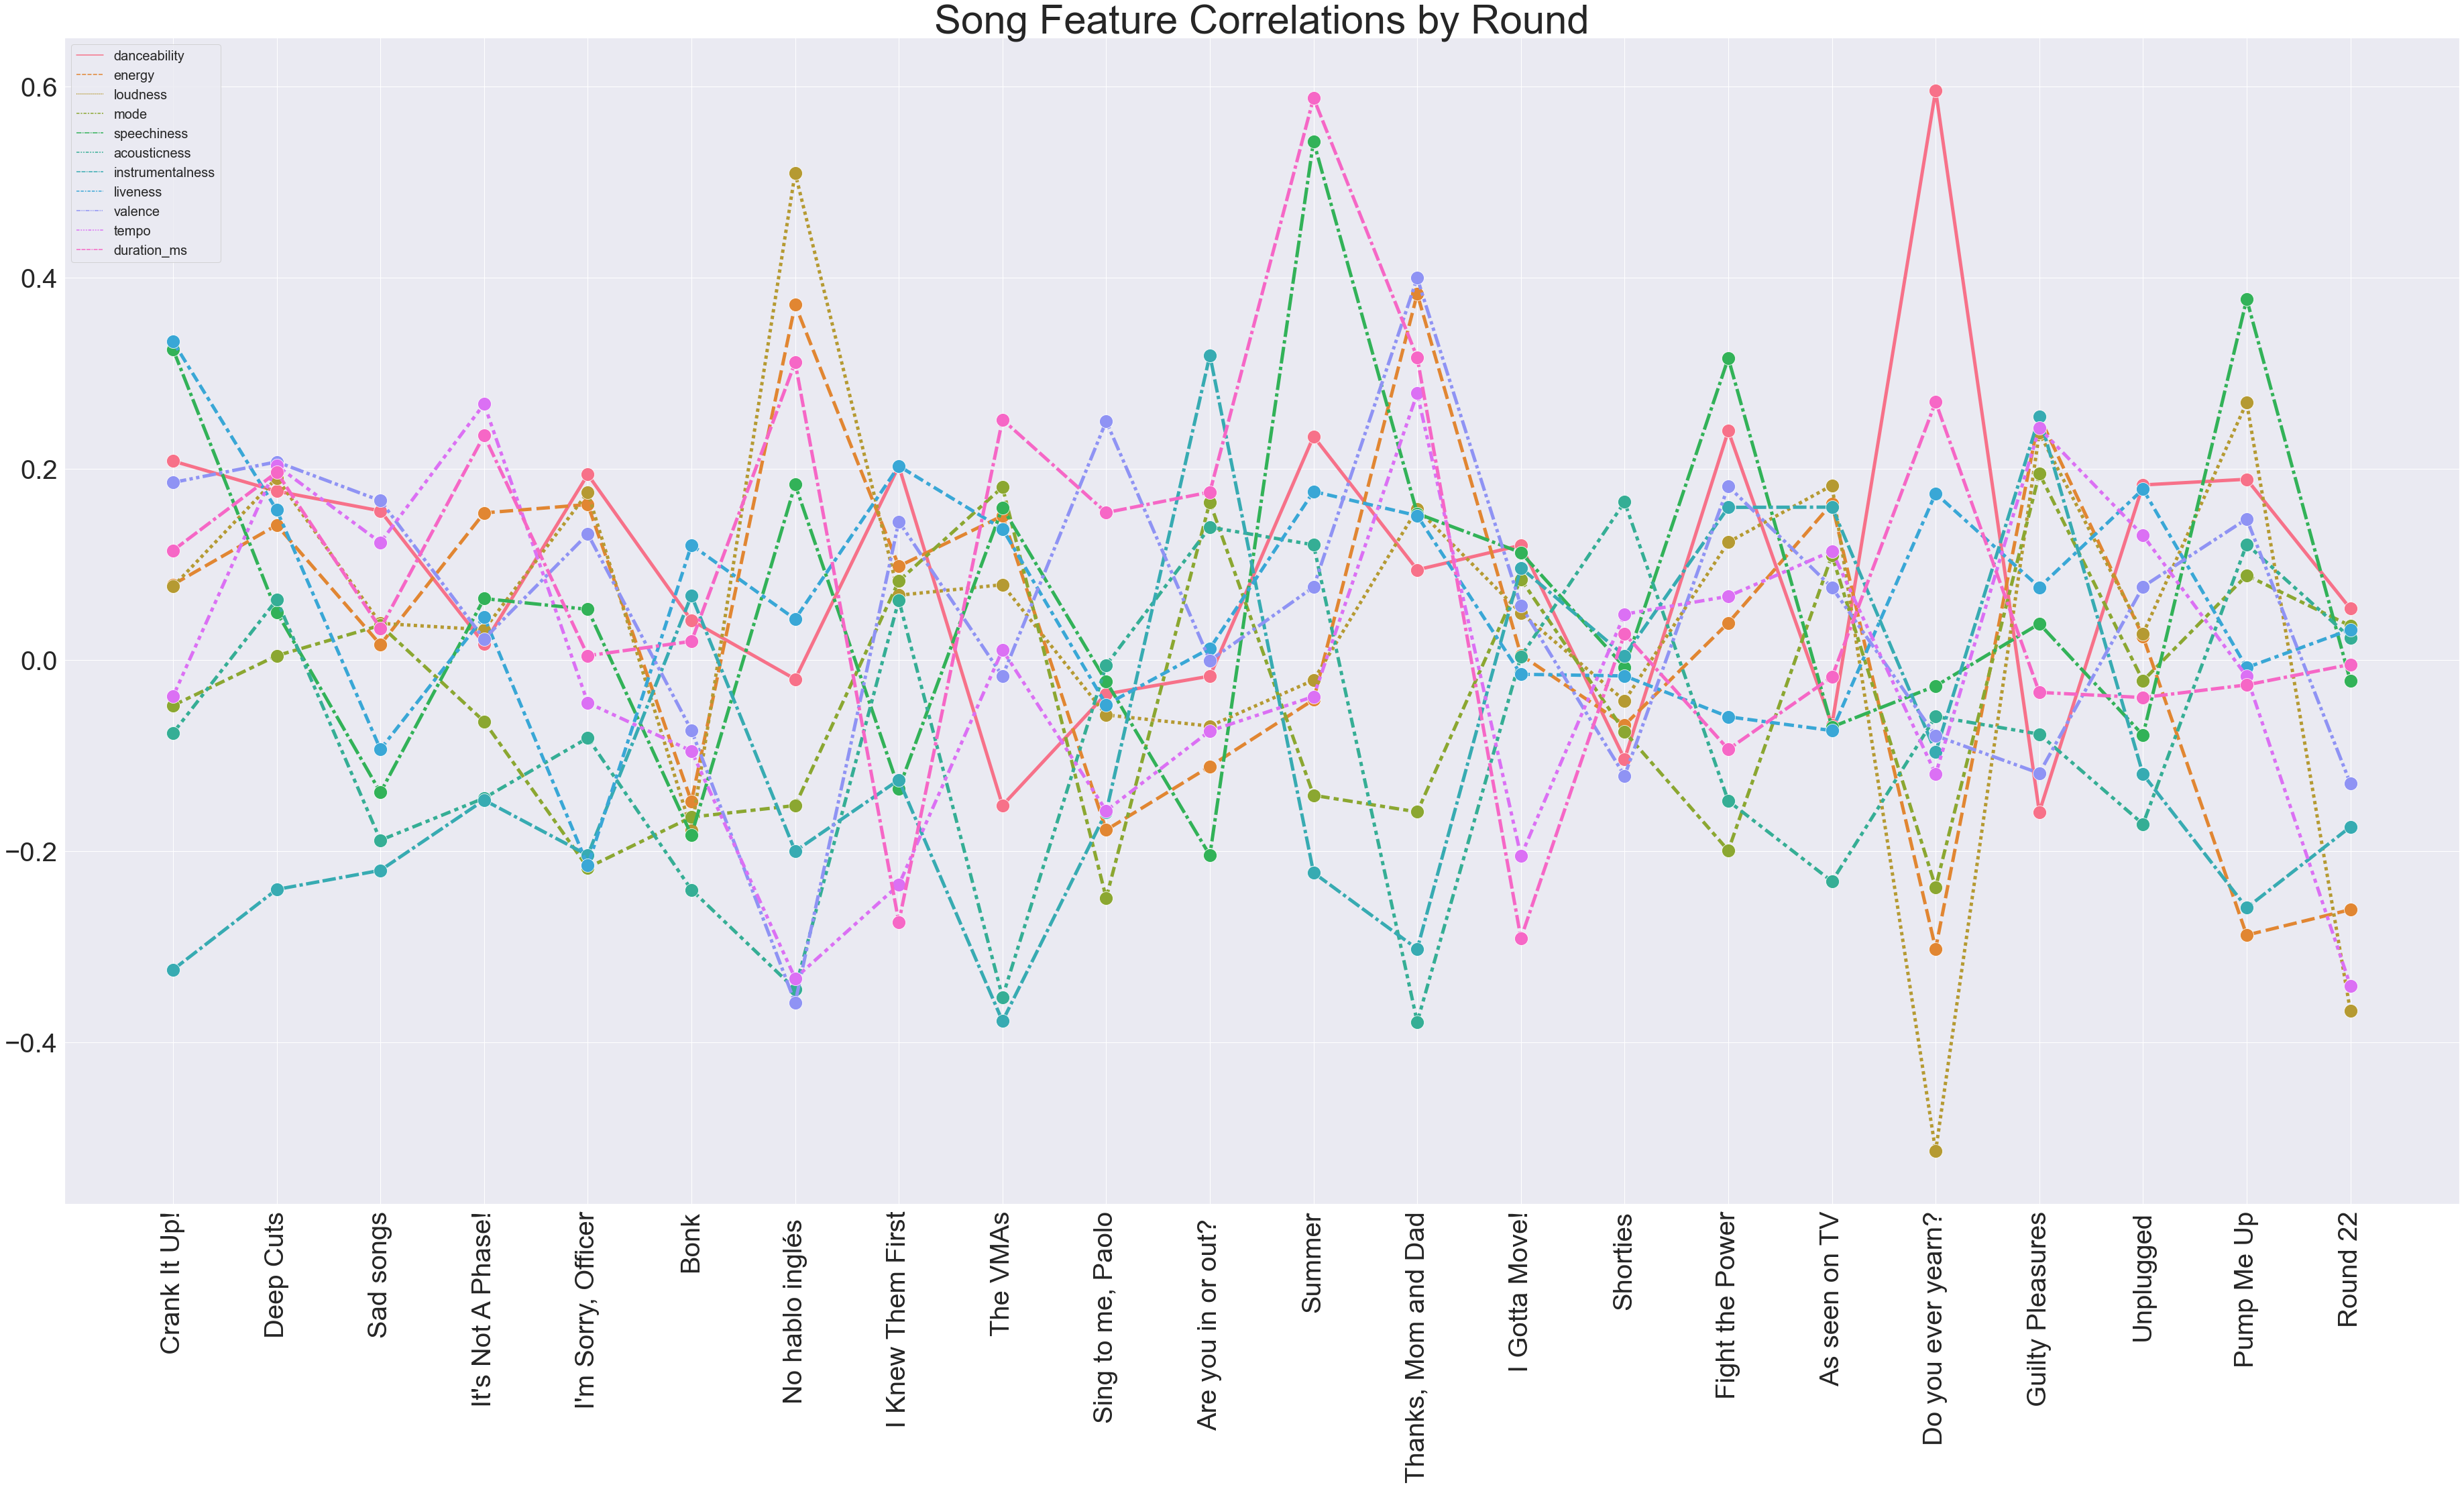

In [27]:
palette = sns.color_palette("rocket_r")

ax = sns.lineplot(data=round_correlations,
                 linewidth=5, 
                 markersize=20,
                 marker='o')

plt.xticks(ticks= list(range(len(round_correlations))), 
           labels=round_correlations['Name'],
           rotation=90,
           size=40)

plt.yticks(size=40)

matplotlib.pyplot.grid(visible=True)

plt.legend(loc=2, prop={'size':20})

plt.title("Song Feature Correlations by Round", size=60)
plt.gcf().set_size_inches(64, 32)
plt.show()


In [28]:
danceability_corr_array = round_correlations[['danceability']].values
energy_corr_array = round_correlations[['energy']].values
loudness_corr_array = round_correlations[['loudness']].values
mode_corr_array = round_correlations[['mode']].values
speechiness_corr_array = round_correlations[['speechiness']].values
acousticness_corr_array = round_correlations[['acousticness']].values
instrumentalness_corr_array = round_correlations[['instrumentalness']].values
liveness_corr_array = round_correlations[['liveness']].values
valence_corr_array = round_correlations[['valence']].values
tempo_corr_array = round_correlations[['tempo']].values
duration_corr_array = round_correlations[['duration_ms']].values
round_list = round_correlations[['Name']].values
t = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


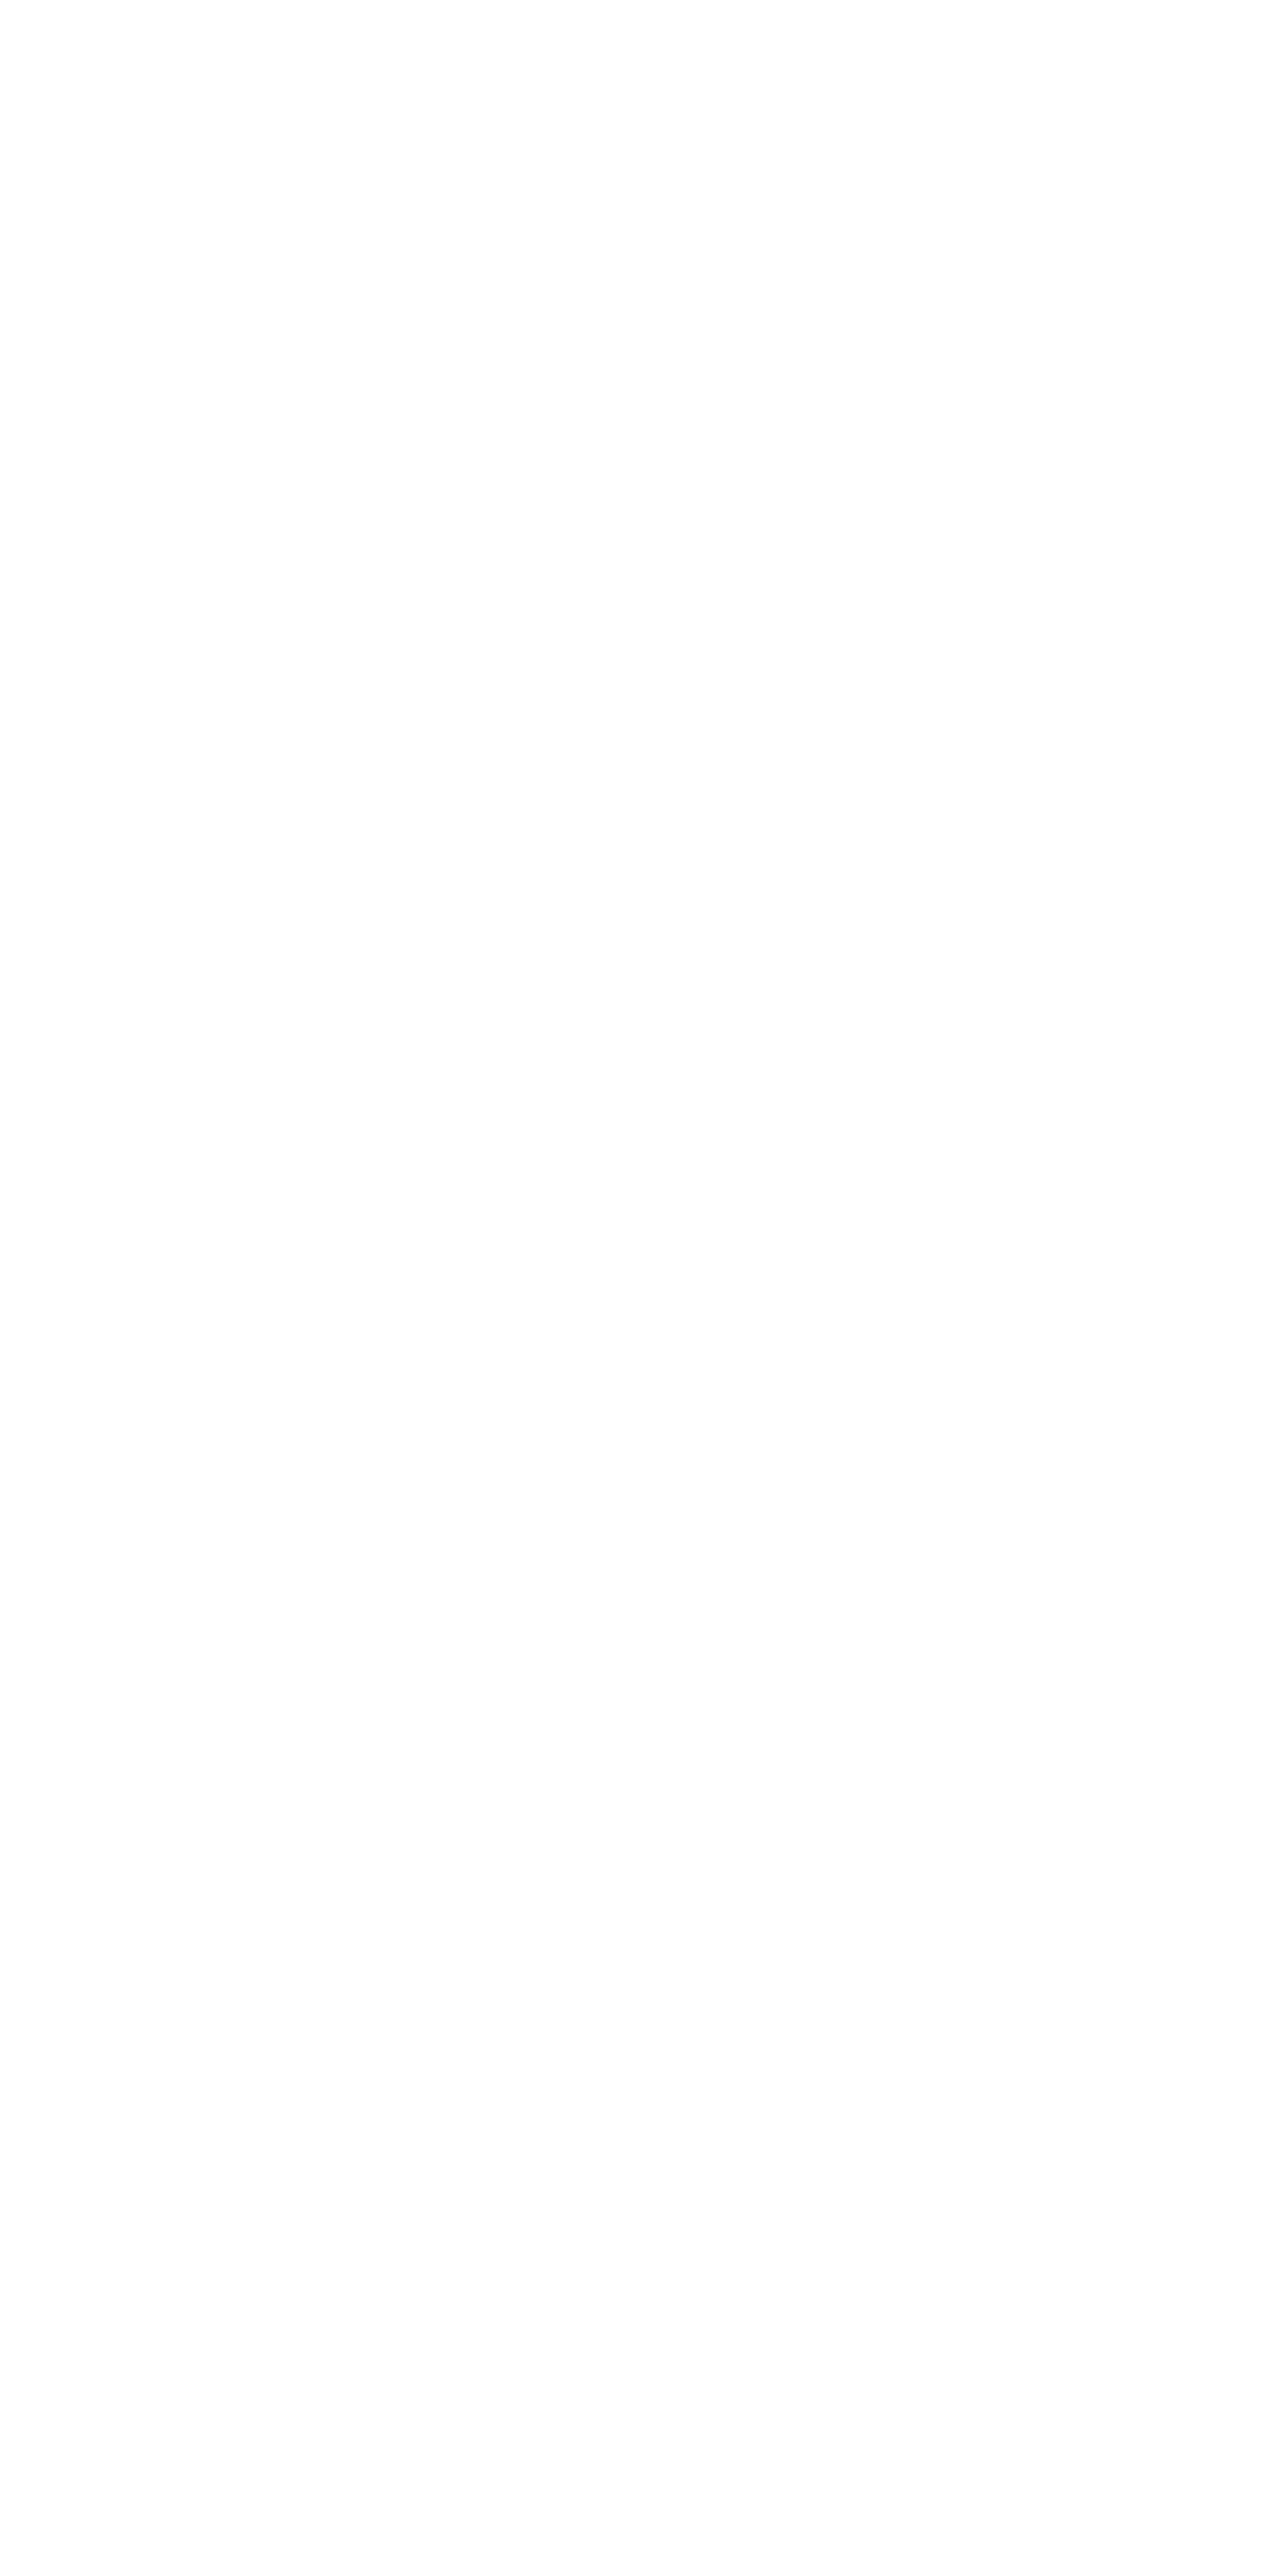

In [30]:
fig, ax = plt.subplots()
ax.set_title('Song Feature Correlations by Round', size=60)
danceability_line, = ax.plot(t, danceability_corr_array, lw=2, label='danceability')
energy_line, = ax.plot(t, energy_corr_array, lw=2, label='energy')
loudness_line, = ax.plot(t, loudness_corr_array, lw=2, label='loudness')
mode_line, = ax.plot(t, mode_corr_array, lw=2, label='mode (1=major, -1=minor)')
speechiness_line, = ax.plot(t, speechiness_corr_array, lw=2, label='speechiness')
acousticness_line, = ax.plot(t, acousticness_corr_array, lw=2, label='acousticness')
instrumentalness_line, = ax.plot(t, instrumentalness_corr_array, lw=2, label='instrumentalness')
liveness_line, = ax.plot(t, liveness_corr_array, lw=2, label='liveness')
valence_line, = ax.plot(t, valence_corr_array, lw=2, label='valence (1=happy, -1=sad)')
tempo_line, = ax.plot(t, tempo_corr_array, lw=2, label='tempo')
duration_line, = ax.plot(t, duration_corr_array, lw=2, label='duration')


leg = ax.legend(fancybox=True, shadow=True, loc=1)

lines = [danceability_line, energy_line, loudness_line, mode_line, speechiness_line, acousticness_line,
        instrumentalness_line, liveness_line, valence_line, tempo_line, duration_line]
lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    lined[legline] = origline


def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

plt.gcf().set_size_inches(10, 20)
fig.canvas.mpl_connect('pick_event', on_pick)
plt.show()

In [31]:
import mpld3
from mpld3 import plugins
from mpld3.utils import get_id
import numpy as np
import collections
import matplotlib.pyplot as plt

In [32]:
%matplotlib inline

In [33]:
#see how each variable's impact changes round to round 
#first, add a field for round name to song_feature_analysis
#create a new df that has as many rows as rounds completed
#in the columns, have the factors - danceability, energy, etc... 
#for each row in the new df, run correlations for all songs where the round id matches
#graph the new df

In [34]:
#break for cleanliness

In [35]:
points_for = points_for.reset_index()

In [36]:
#clean up votes_for and votes_cast before merging into votes_for
votes_cast.rename(columns={'Points_Assigned': 'total_points_cast'}, inplace=True)
votes_cast = votes_cast.reset_index()
votes_for = votes_for.reset_index()

votes_for.rename(columns={'Points_Assigned': 'num_times_voted'}, inplace=True)

In [37]:
#reducing the votes_for and points_for tables into voter,submitter, and the relevant counts
del votes_for['Spotify_URI']
del votes_for['Created_voter']
del votes_for['Comment_voter']
del votes_for['Round_ID']
del votes_for['Created_submitter']
del votes_for['Comment_submitter']
del votes_for['ID_voter']
del votes_for['ID_submitter']
del votes_for['Voter_ID']
del votes_for['Submitter_ID']

votes_for.head()

,Name_voter,Name_submitter,num_times_voted
0,Aidanread27,Allison,13
1,Aidanread27,Angela,10
2,Aidanread27,Brendon Y,11
3,Aidanread27,Carl,11
4,Aidanread27,Dan,12


In [38]:
#combine the votes_cast table with points_for
points_for = points_for.merge(votes_cast, how='left', on=['Name_voter'])

In [39]:
avg_vote = votes_for.merge(points_for[['Name_voter', 'Name_submitter', 'Points_Assigned']], how='left', on=['Name_voter', 'Name_submitter'])
avg_vote["per_instance_avg"]=(avg_vote["Points_Assigned"]/avg_vote["num_times_voted"])
avg_vote = avg_vote.round({'per_instance_avg': 1})

In [40]:
#sns.scatterplot(x=points_for['Name_voter'],y=points_for['Name_submitter'],size=points_for['Points_Assigned'], sizes=(0,2500))
#plt.gcf().set_size_inches(32, 32)

In [41]:
#once they're merged, figure out what vote share goes to each other person
points_for["percent_share"]=(points_for["Points_Assigned"]/points_for["total_points_cast"])*100
percent_votes=points_for

In [42]:
#replace NaN with 0
percent_votes.fillna(0)
votes_for.fillna(0)
points_for.fillna(0)
avg_vote.fillna(0)

,Name_voter,Name_submitter,num_times_voted,Points_Assigned,per_instance_avg
0,Aidanread27,Allison,13,28,2.2
1,Aidanread27,Angela,10,22,2.2
2,Aidanread27,Brendon Y,11,23,2.1
3,Aidanread27,Carl,11,21,1.9
4,Aidanread27,Dan,12,27,2.2
...,...,...,...,...,...
2062,y2ckt,nr031197,10,11,1.1
2063,y2ckt,scott,11,14,1.3
2064,y2ckt,sean,11,20,1.8
2065,y2ckt,seth,3,3,1.0


In [43]:
#doing the pivot tables
percent_votes_t = percent_votes.pivot(index='Name_voter', columns='Name_submitter', values='percent_share')
votes_for_t = votes_for.pivot(index='Name_voter', columns='Name_submitter', values='num_times_voted')
points_for_t = points_for.pivot(index='Name_voter', columns='Name_submitter', values='Points_Assigned')
avg_vote_t = avg_vote.pivot(index='Name_voter', columns='Name_submitter', values='per_instance_avg') 

In [44]:
#replace NaN with 0
percent_votes_t = percent_votes_t.fillna(0)
votes_for_t = votes_for_t.fillna(0)
points_for_t = points_for_t.fillna(0)
avg_vote_t = avg_vote_t.fillna(0)

In [45]:
def print_heatmap(df, title):
    ax = sns.heatmap(df,xticklabels=True, yticklabels=True, annot=True, linewidths=.25, center=0, cmap="YlGnBu", cbar=False)
    plt.title(title)
    plt.gcf().set_size_inches(32, 32)

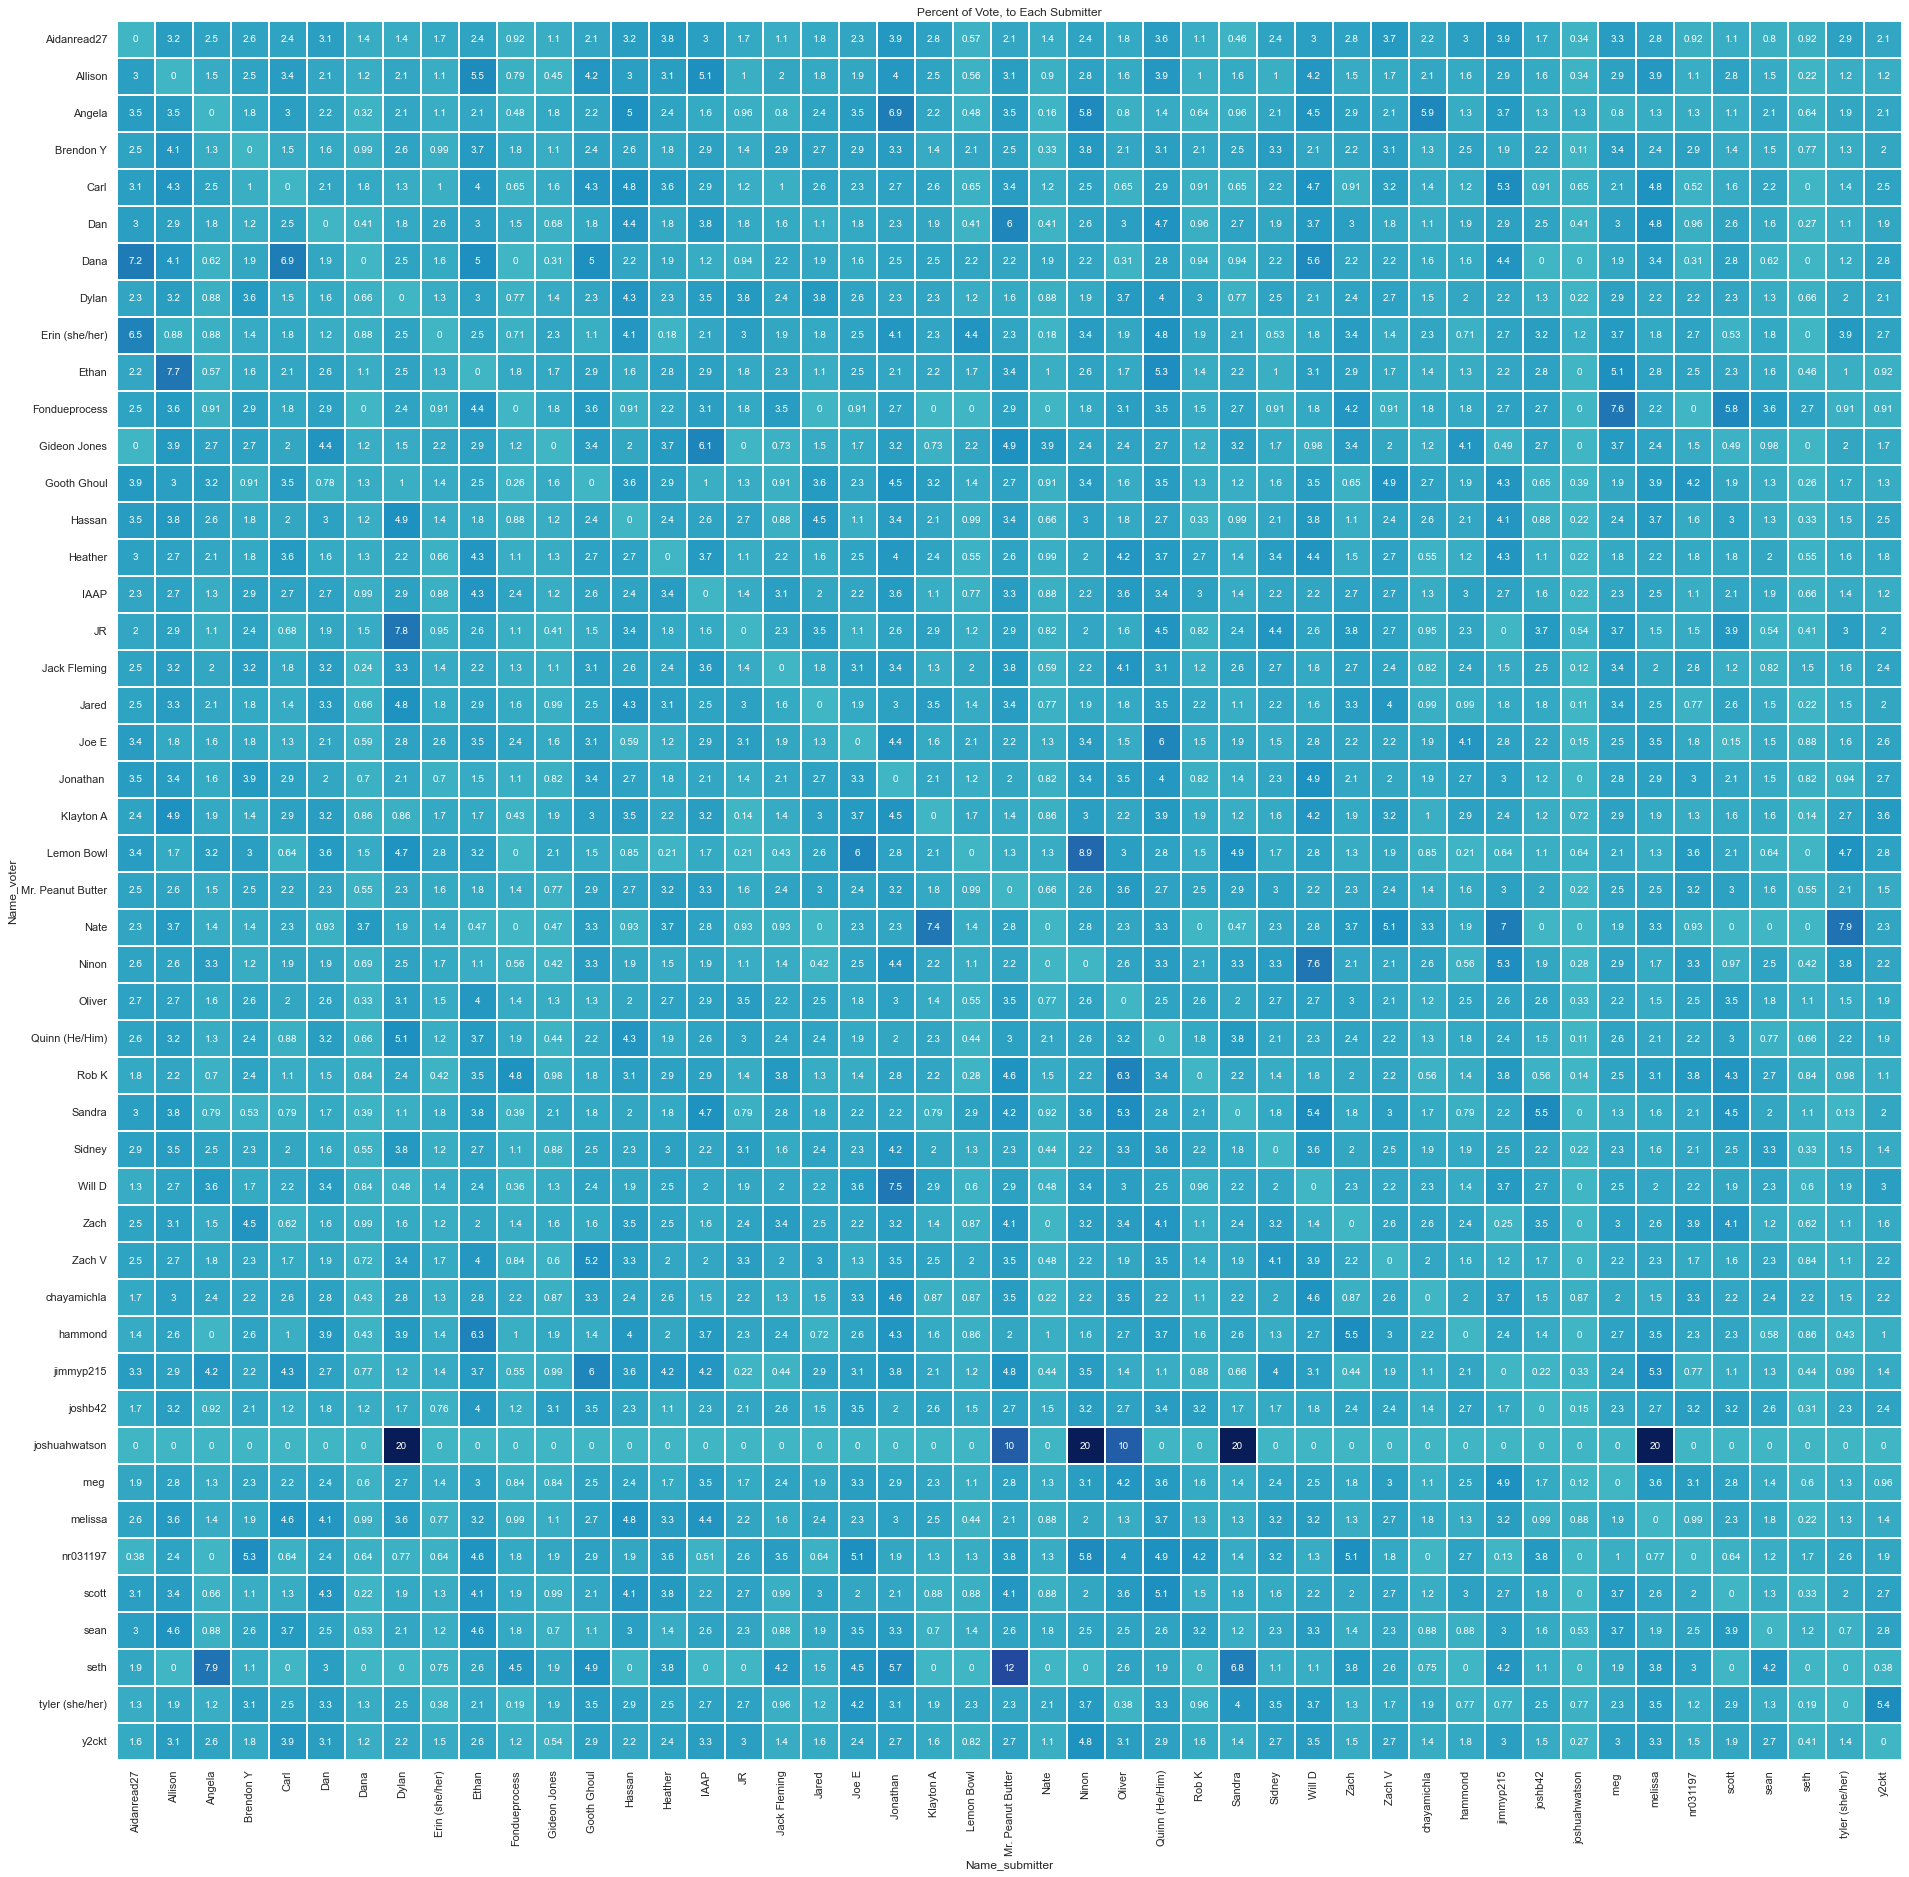

In [46]:
print_heatmap(percent_votes_t, "Percent of Vote, to Each Submitter")

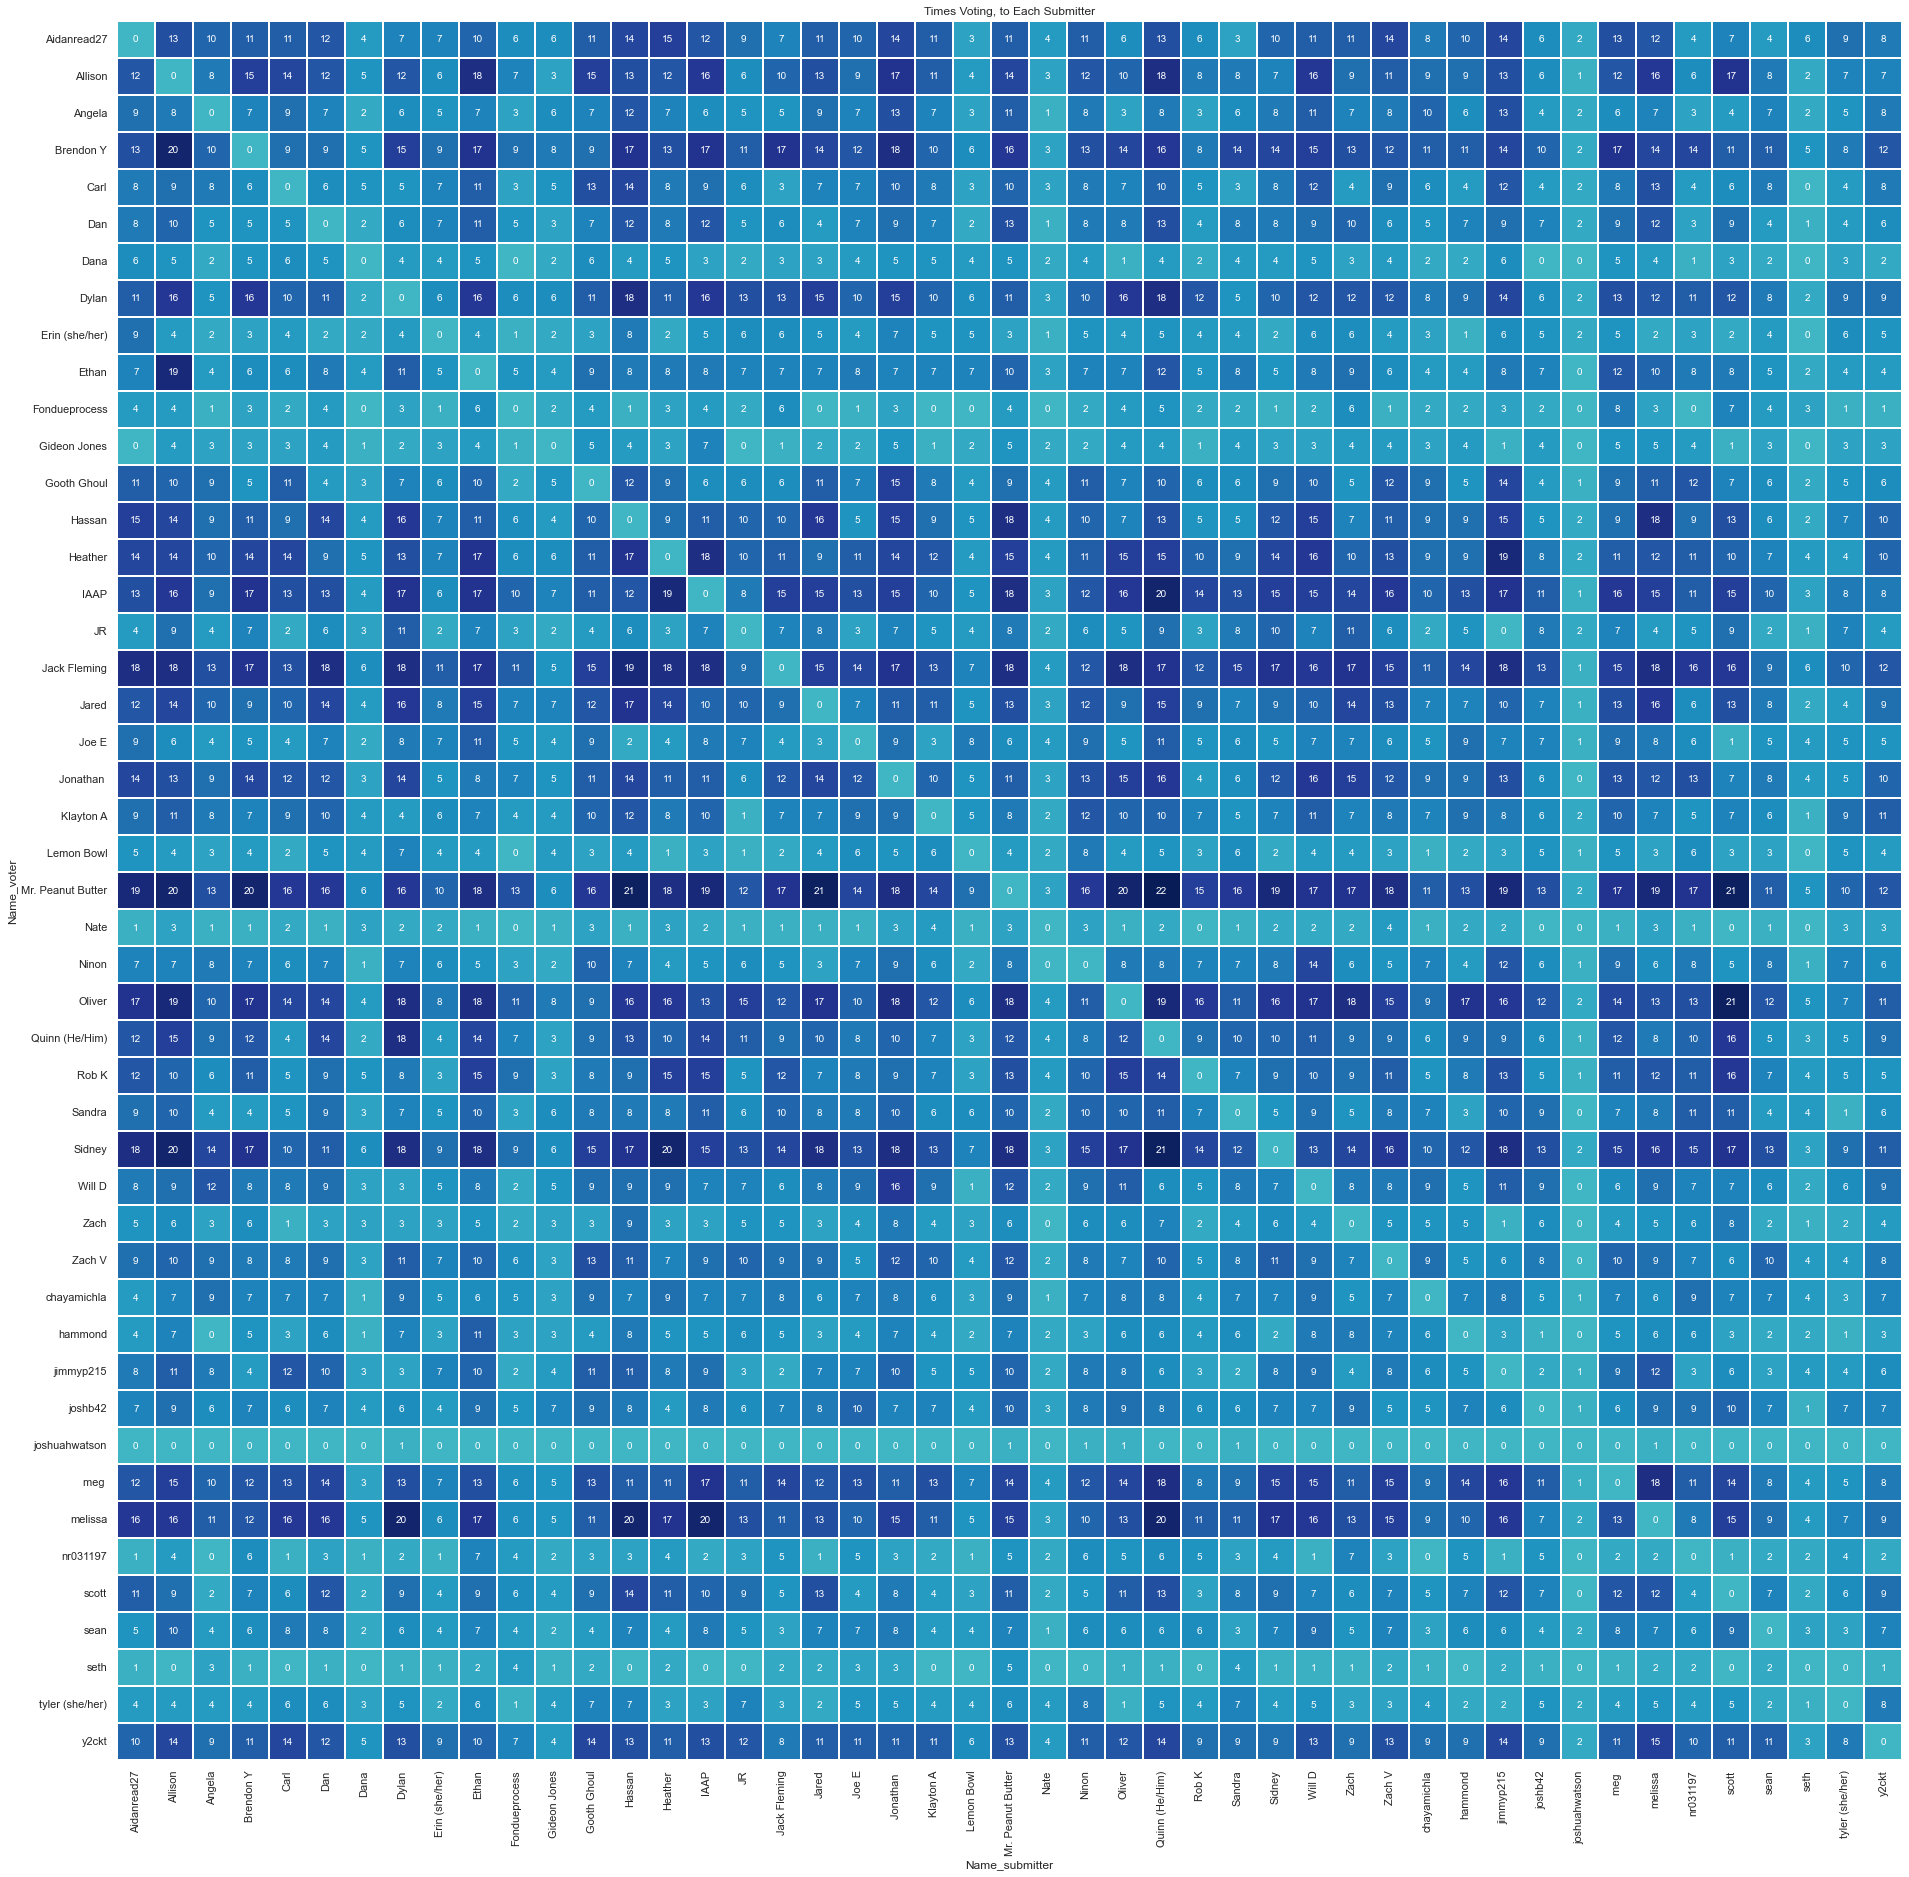

In [47]:
print_heatmap(votes_for_t, "Times Voting, to Each Submitter")

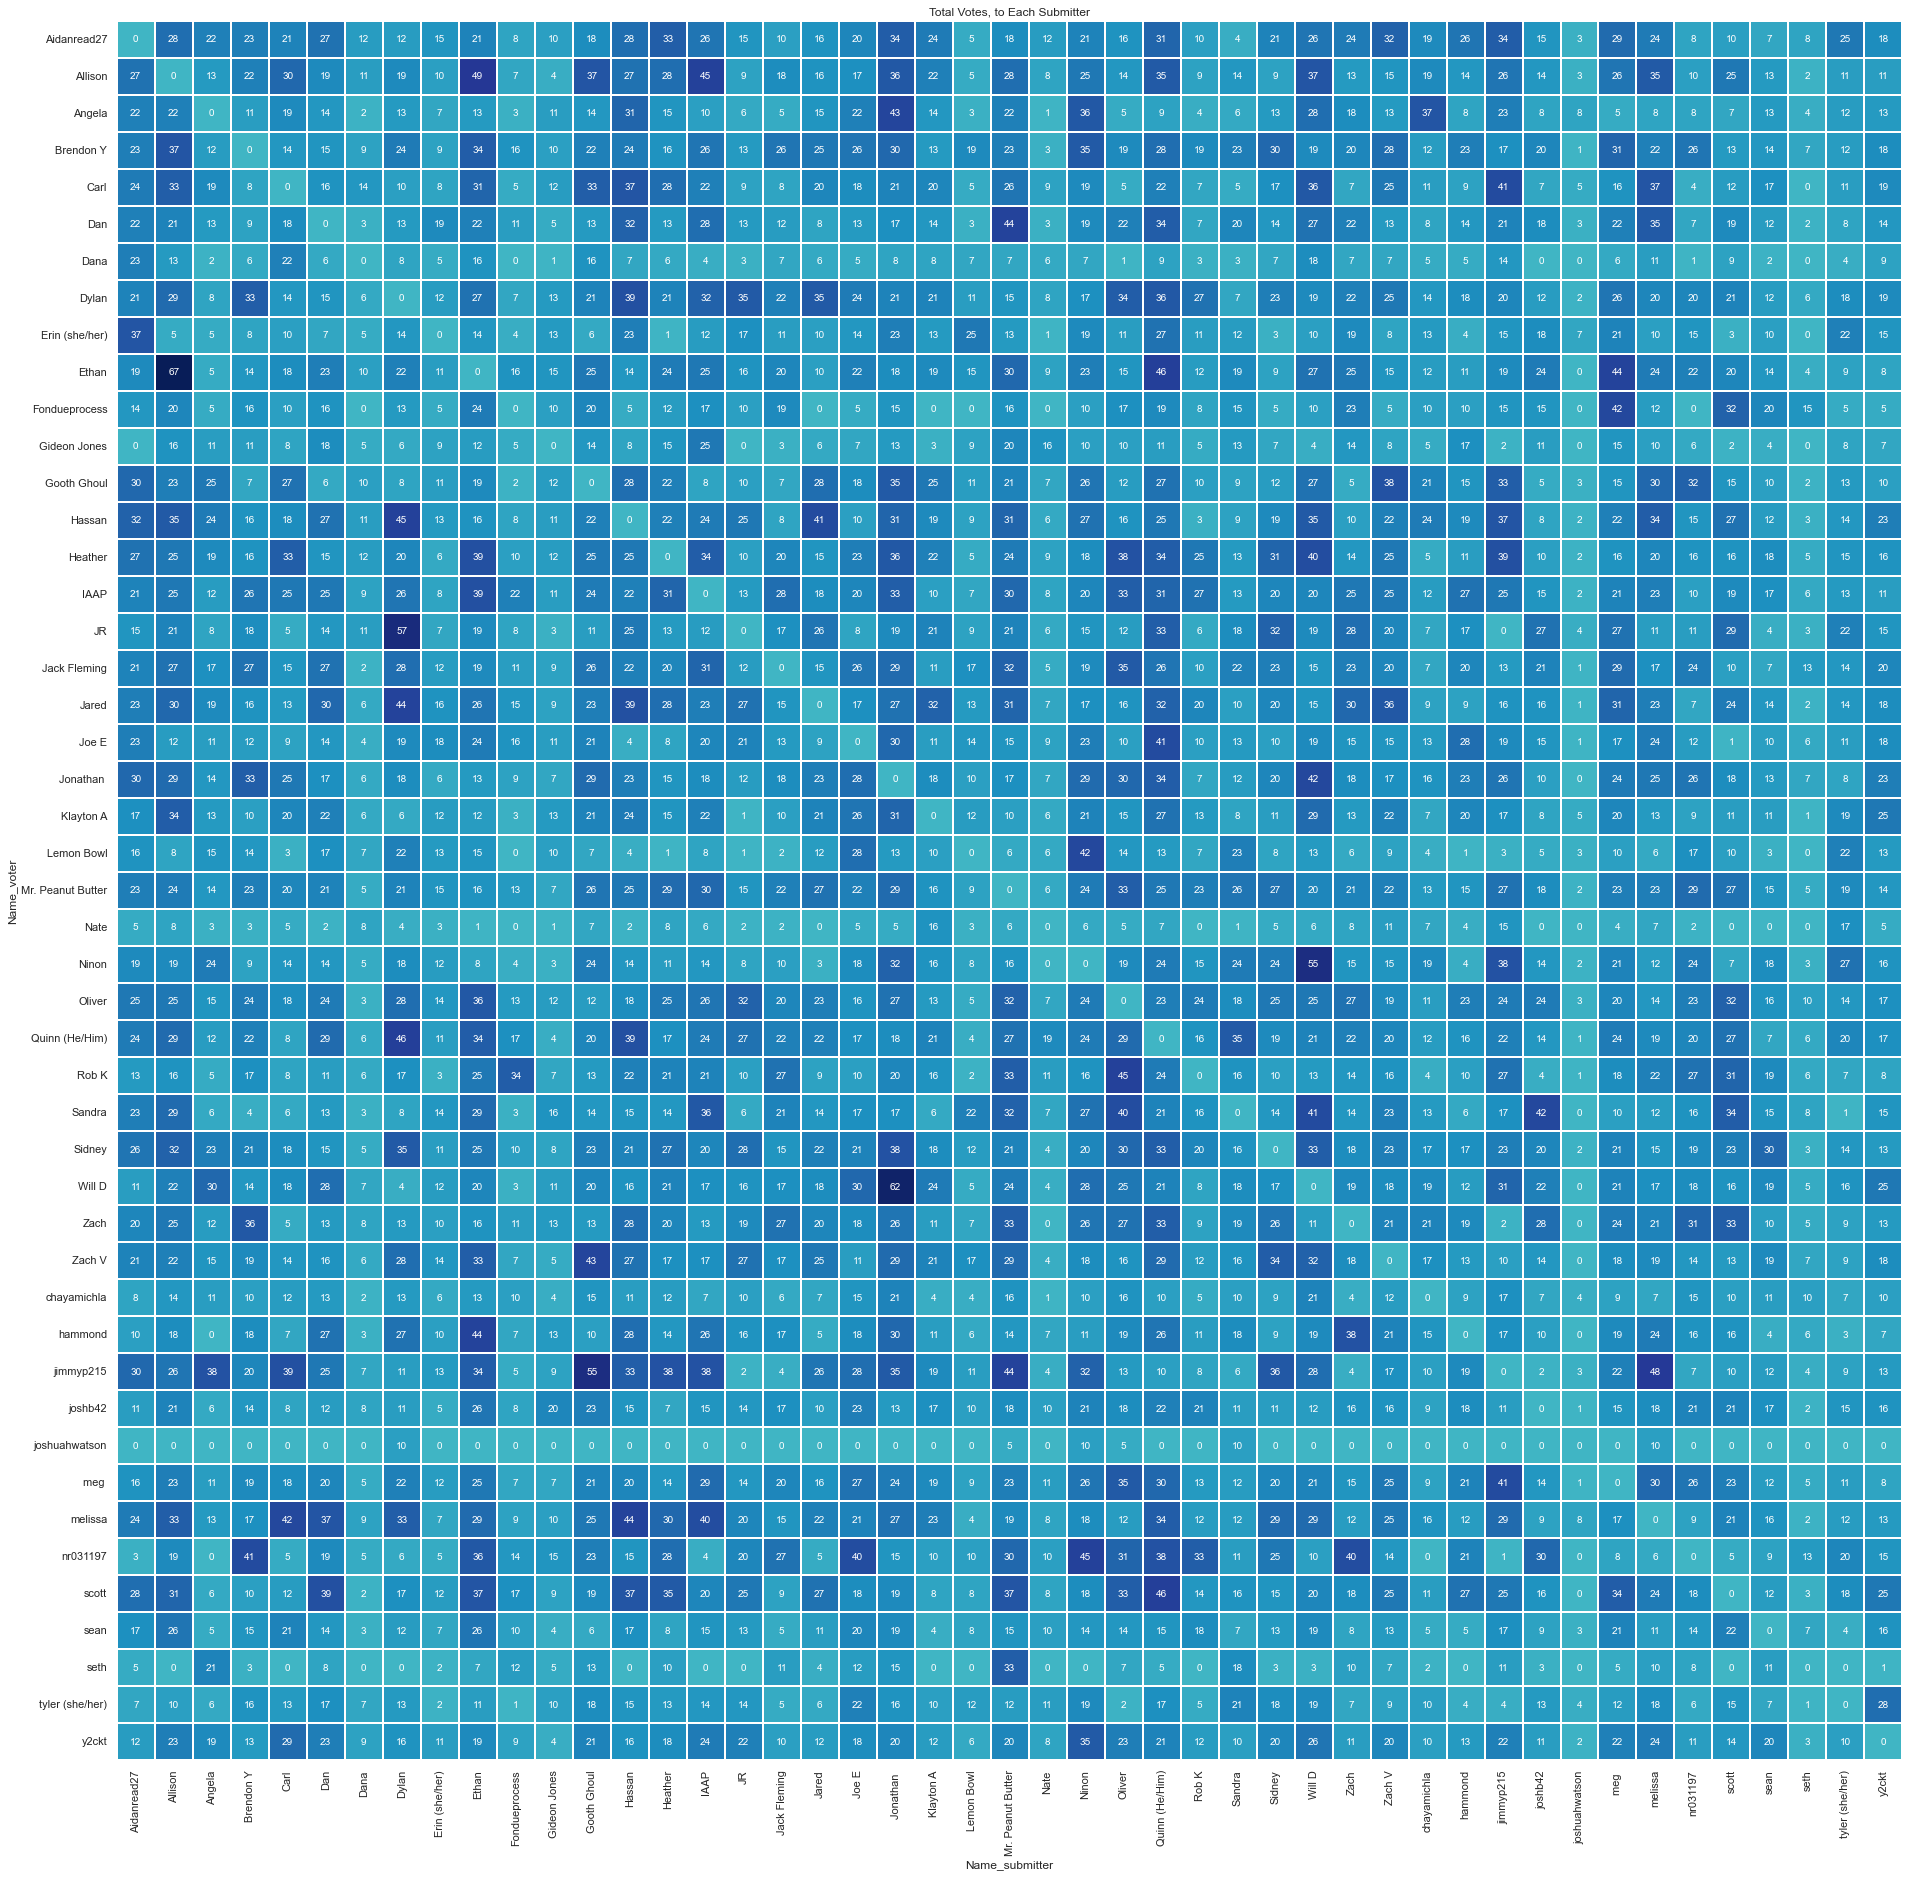

In [48]:
print_heatmap(points_for_t, "Total Votes, to Each Submitter")

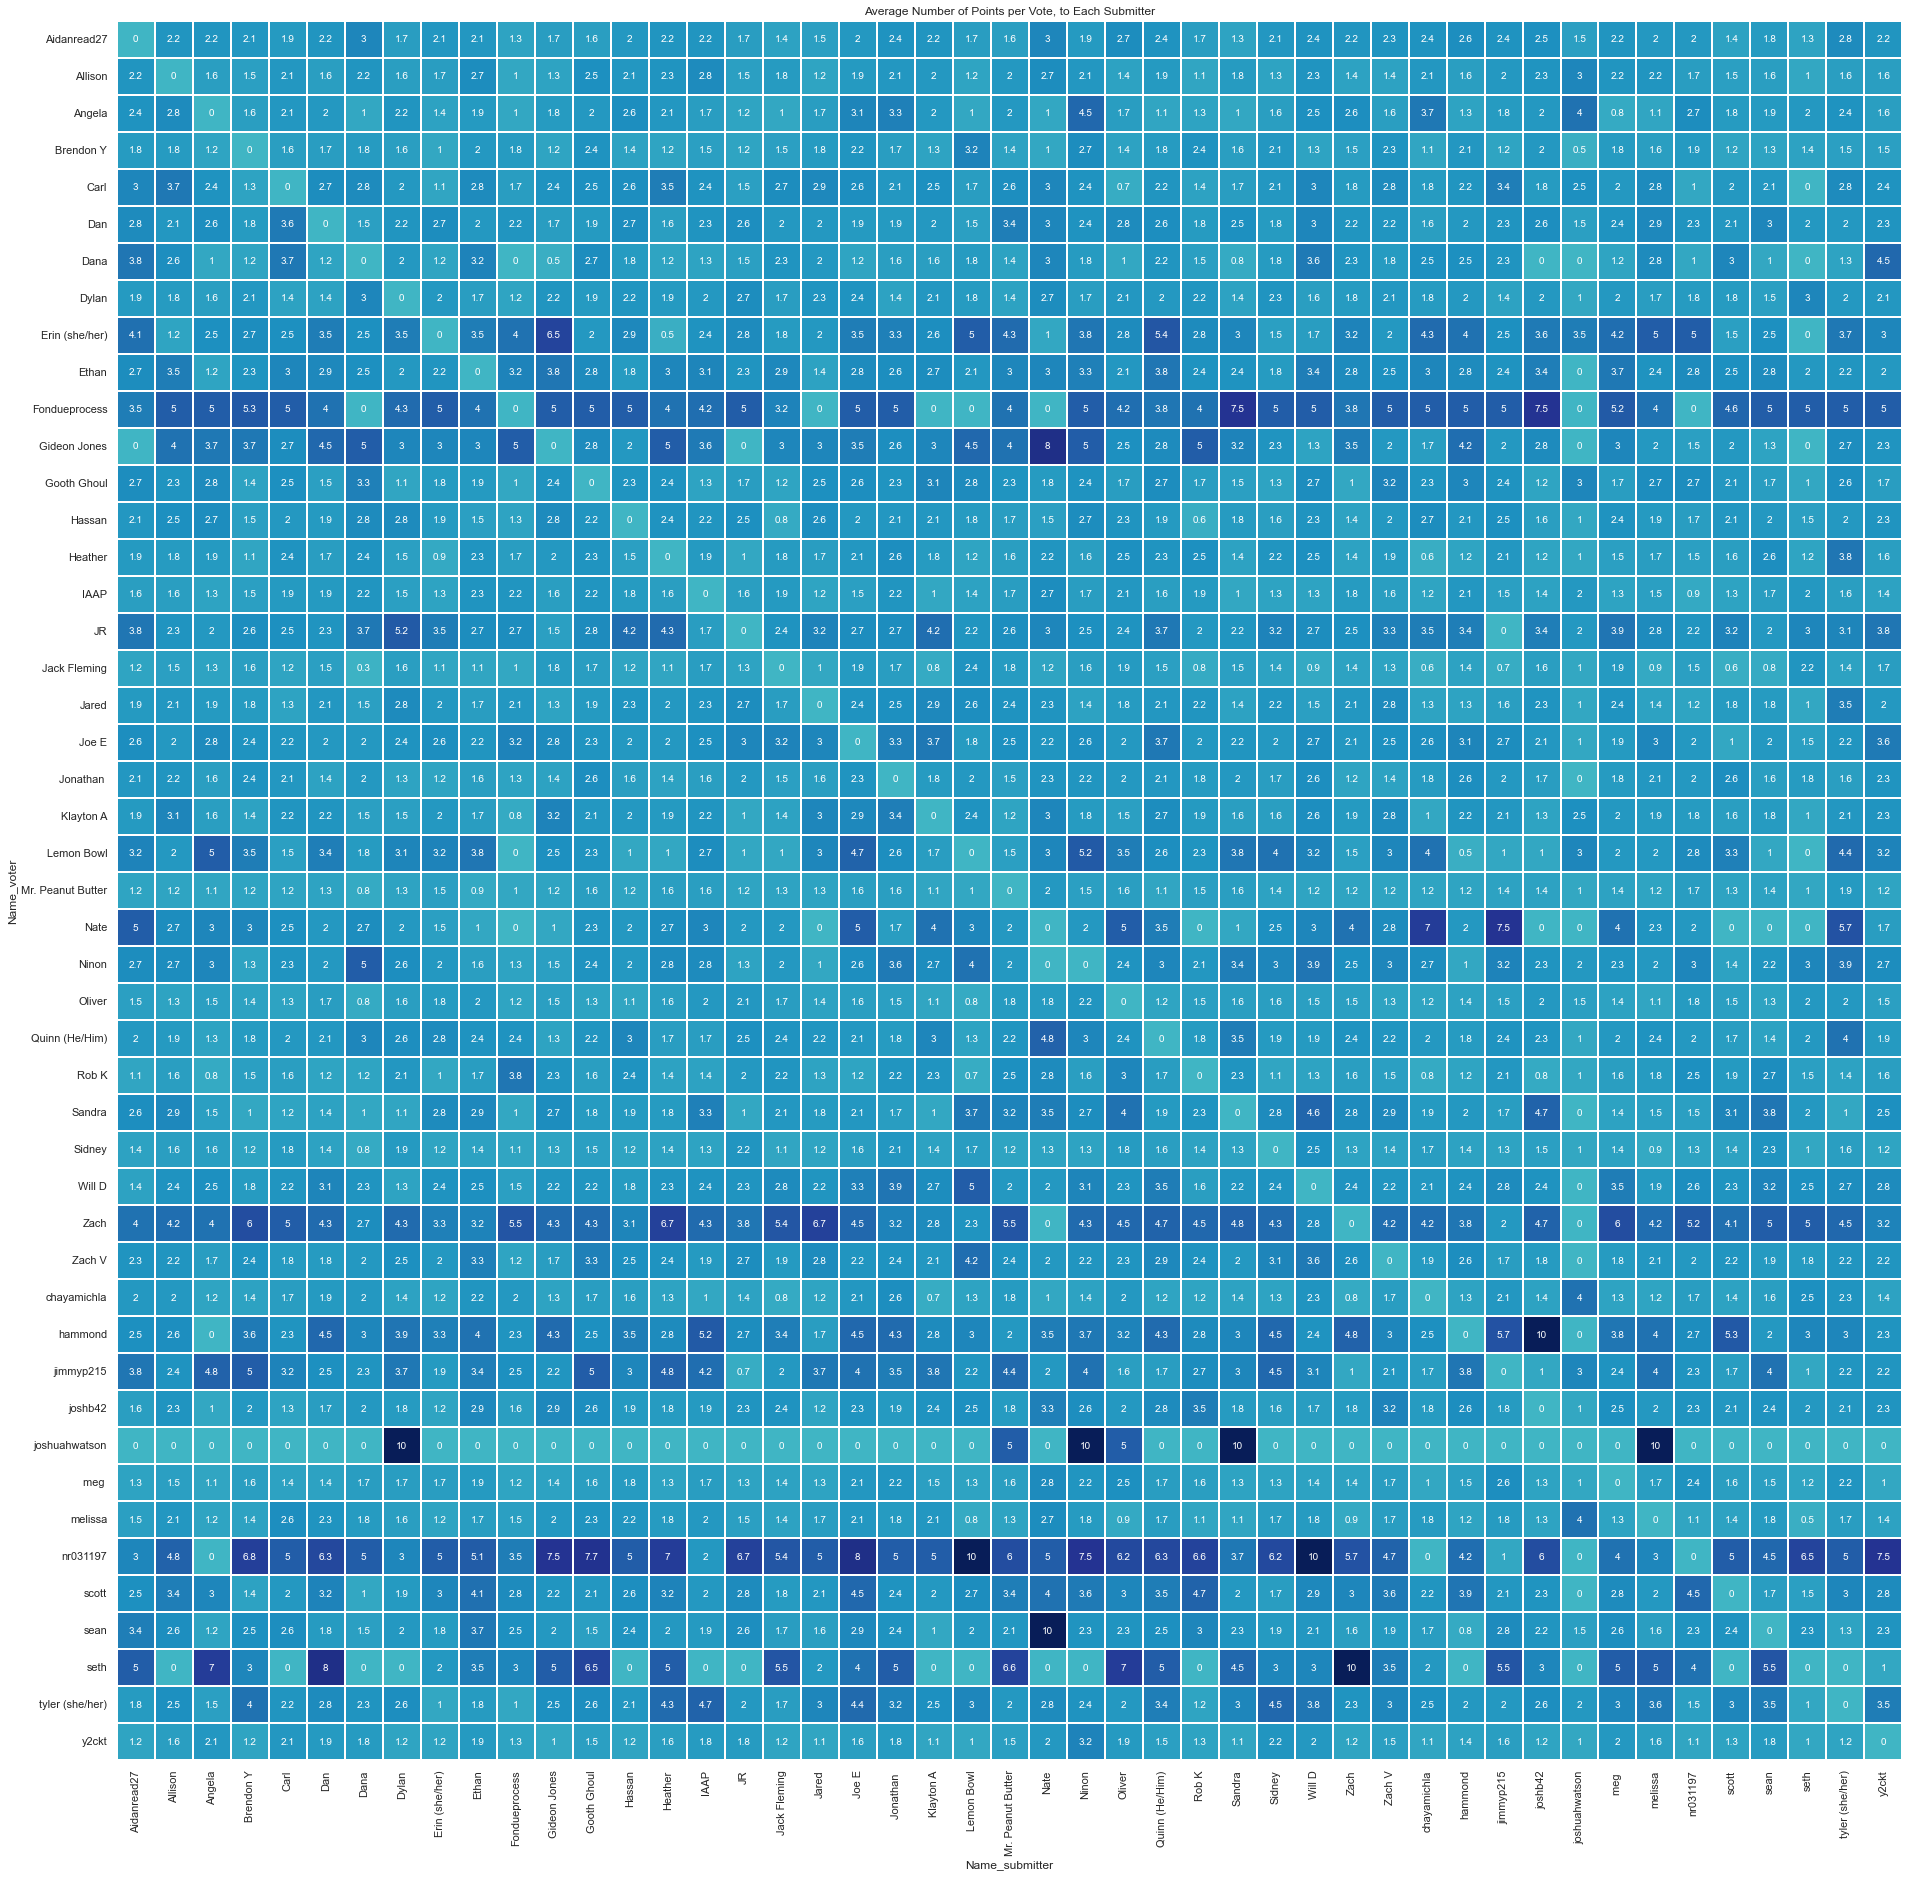

In [49]:
print_heatmap(avg_vote_t, "Average Number of Points per Vote, to Each Submitter")

In [50]:
#here, I create points_for_array and tranpose points_for_t so that the columns represent who the voter voted for
#that way, I can compare using .corr() from one column to the next 
points_for_array = points_for_t.transpose()
correlation_scores = points_for_array.corr()
correlation_scores = correlation_scores.round(2)
correlation_scores = correlation_scores.fillna(0)
correlation_scores.head()

Name_voter,Aidanread27,Allison,Angela,Brendon Y,Carl,Dan,Dana,Dylan,Erin (she/her),Ethan,...,joshb42,joshuahwatson,meg,melissa,nr031197,scott,sean,seth,tyler (she/her),y2ckt
Name_voter,,,,,,,,,,,,,,,,,,,,,
Aidanread27,1.00,0.47,0.43,0.33,0.57,0.38,0.25,0.48,0.03,0.37,...,0.21,-0.12,0.46,0.54,0.24,0.53,0.34,0.07,0.24,0.56
Allison,0.47,1.00,0.40,0.37,0.58,0.61,0.58,0.37,0.27,0.19,...,0.33,0.13,0.52,0.56,0.11,0.43,0.42,0.21,0.40,0.58
Angela,0.43,0.40,1.00,0.36,0.46,0.31,0.42,0.20,0.36,0.20,...,0.16,0.08,0.33,0.49,0.12,0.26,0.33,0.09,0.32,0.39
Brendon Y,0.33,0.37,0.36,1.00,0.42,0.48,0.32,0.42,0.37,0.51,...,0.52,0.25,0.48,0.40,0.29,0.57,0.51,0.18,0.29,0.50
Carl,0.57,0.58,0.46,0.42,1.00,0.54,0.52,0.38,0.14,0.33,...,0.33,0.03,0.48,0.49,0.00,0.52,0.35,0.23,0.33,0.48


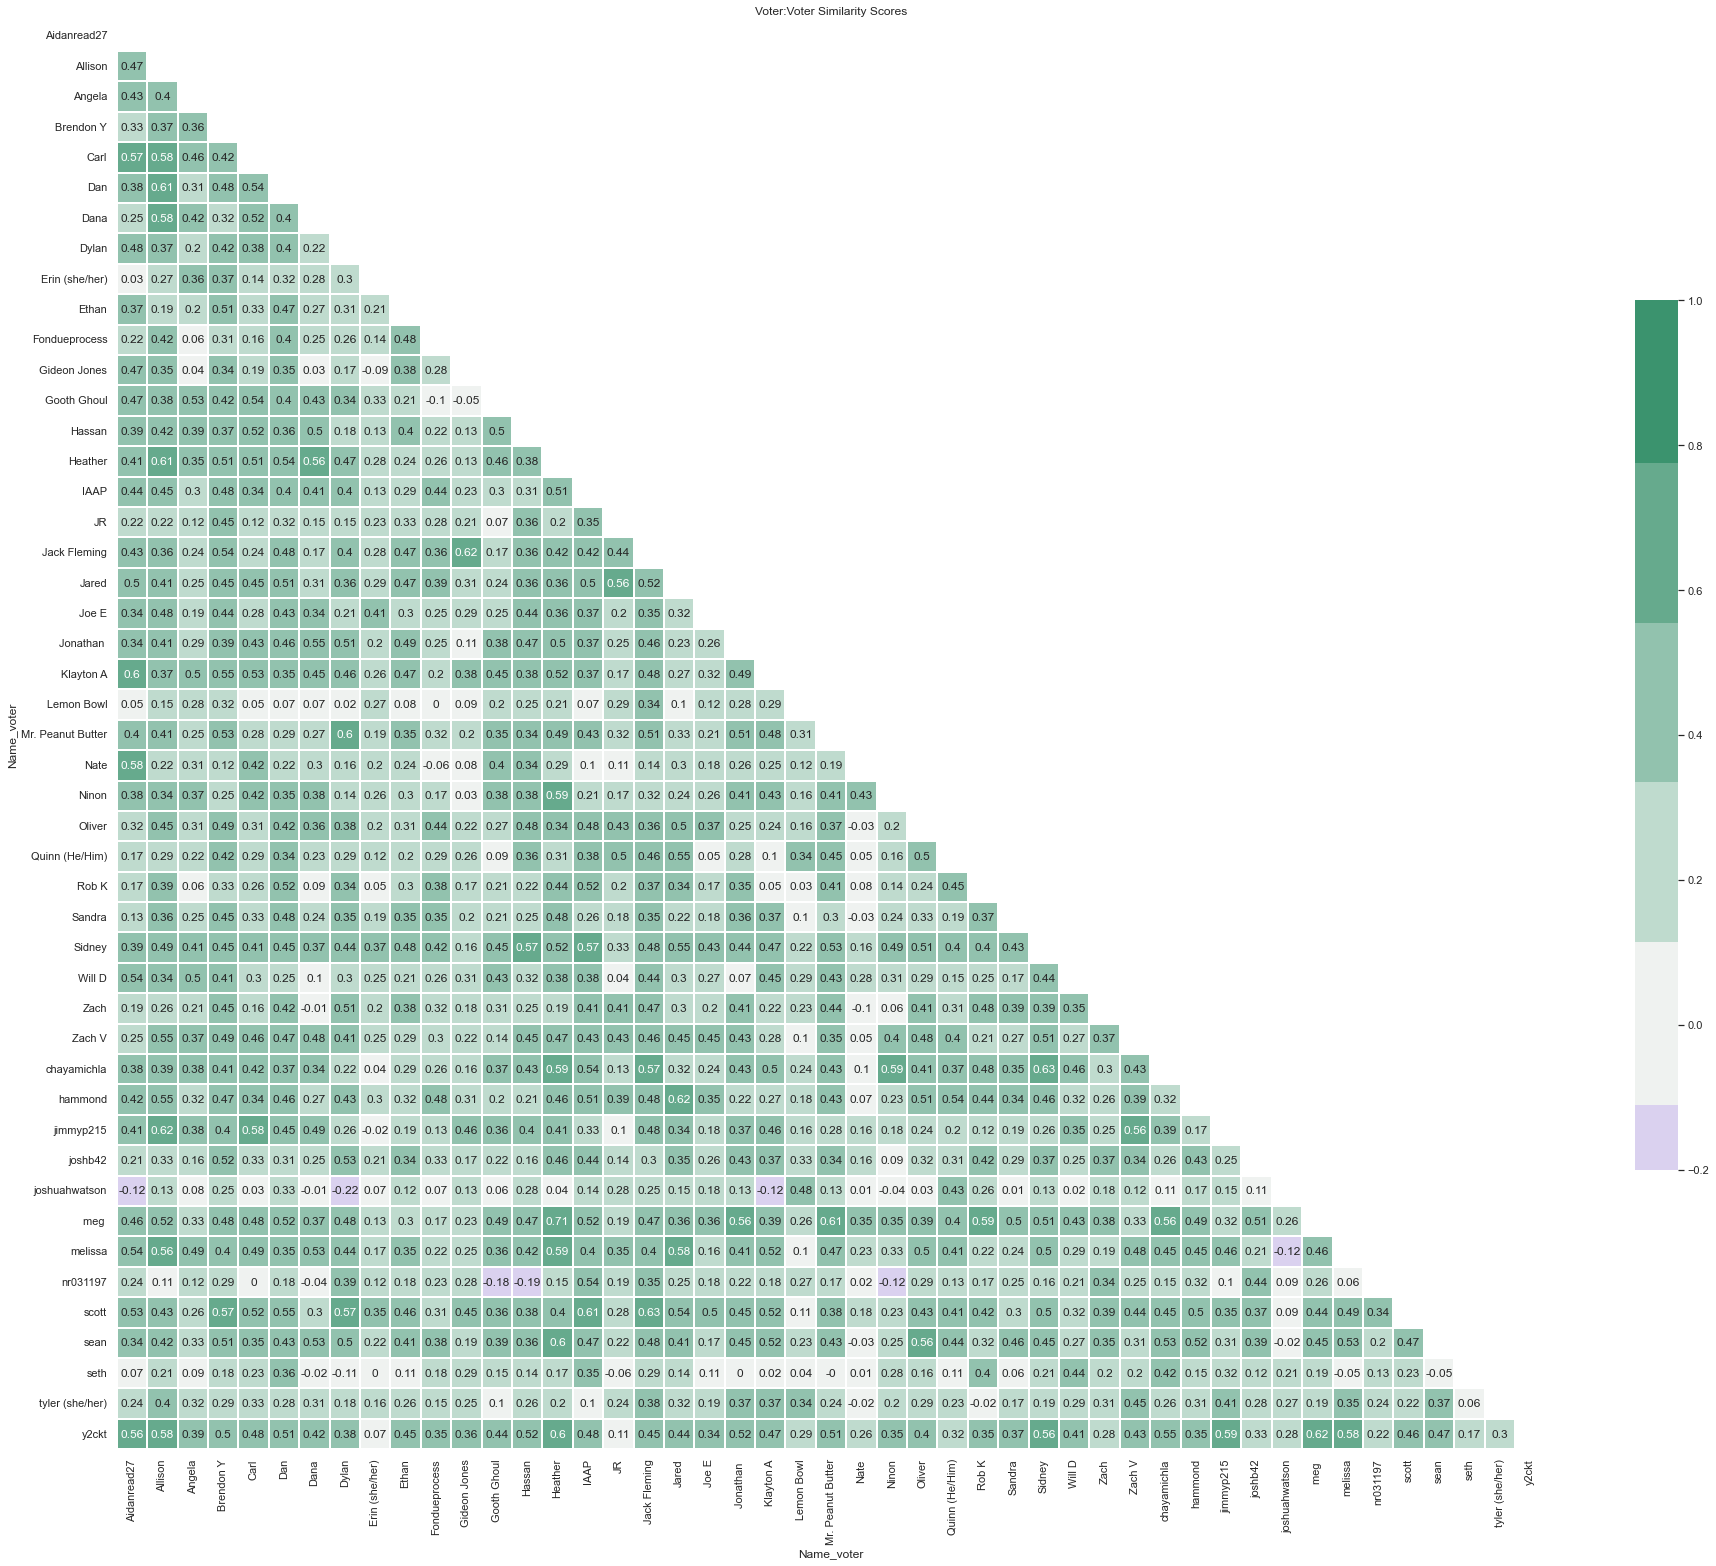

In [51]:
#heatmap for similarity in voting
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_scores, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(275, 150, s=80, l=55, n=9)


#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_scores, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-.2,
            square=True, linewidths=.25, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True, annot=True)

plt.title('Voter:Voter Similarity Scores')
plt.gcf().set_size_inches(32, 32)

In [52]:
#trying out cluster mapping
#sns.clustermap(correlation_scores,xticklabels=True, yticklabels=True, annot=True, linewidths=.25, center=0, cmap="YlGnBu", cbar=False)
#plt.title('clustermap')
#plt.gcf().set_size_inches(32, 32)

In [53]:
# % of your votes that went to the bottom 3 of each round
# % of your votes that went to the top 3 of each round
# to start out, need to figure out what's the order of songs in each round

round_song_sum = vote_and_submissions.groupby(['Round_ID', 'Name_submitter']).sum('Points_Assigned')
round_song_sum.rename(columns={'Points_Assigned': 'Points_Received'}, inplace=True)
e = round_song_sum.groupby('Round_ID').size()
num_per_round = pd.DataFrame(e)
num_per_round.rename(columns={0: 'count_songs'}, inplace=True)

In [54]:
#make a new df to capture competitor names, which we'll use to put round submission totals in
a=0
iter = len(competitors)
for a in range (a, iter):

    new_col = competitors.at[a,'Name']
    num_per_round[new_col]="0"
    num_per_round[new_col] = pd.to_numeric(num_per_round[new_col])

In [55]:
num_per_round = num_per_round.reset_index()

In [56]:
#here 

a = 0
b = 0
c = 0
x=0
y=0

#apply this to each round in the round spreadsheet
for a in range (0,len(num_per_round)):
    
    current_round_ID = num_per_round.at[a,'Round_ID']
    
    #while focusing in on a round, check each participant
    for b in range (2,len(num_per_round.columns)):
        
        current_competitor_name = num_per_round.columns[b]

        #with those two variables, run through every row of the vote_and_submissions df
        for c in range (0,len(vote_and_submissions)):
       
            #maybe something here with like a while x < 1 that increments once it happens once
        
            #first, see if the row in v_a_s's round matches the current one
            if vote_and_submissions.at[c,'Round_ID'] == current_round_ID:
                
                #if so, check to see if the participant name is the same. if y add a point
                if vote_and_submissions.at[c,'Name_voter'] == current_competitor_name:
                
                    num_per_round.iat[a,b]+=1
                    
            else:

                y+=1


In [57]:


competitor_total_engagements = pd.DataFrame()
competitor_total_engagements.loc(0)
#'Songs_voted_on', 'Num_rounds_in'

a=0
iter = len(competitors)
for a in range (a, iter):

    new_col = competitors.at[a,'Name']
    competitor_total_engagements[new_col]= ""
    competitor_total_engagements.at[0,new_col]= 0
    competitor_total_engagements[new_col] = pd.to_numeric(competitor_total_engagements[new_col])

In [58]:
#here i'll see the number of songs that each competitor interacted with. 

a = 0
b = 0
c = 0
x = 0
y = 0

#apply this to each round in the round spreadsheet
for a in range (2,len(num_per_round.columns)):
    
    round_competitor = num_per_round.columns[a]
    
    #while focusing in on a round, check each participant
    for b in range (0,len(competitor_total_engagements.columns)):

        check_competitor = competitor_total_engagements.columns[b]
        
        #if the two columns match...
        if round_competitor == check_competitor:

            #run a for loop within the num_per_round sheet to get all the rows where their engagement !=0
            for c in range (0,len(num_per_round)):
                                
                    if num_per_round.iat[c,a] > 0:
                        
                        #assign a variable to the number in the round's total cells
                        x = num_per_round.iat[c,1]
                        
                        #add that to a variable for this person's total engaged
                        competitor_total_engagements.iat[0,b] = competitor_total_engagements.iat[0,b]+x

In [59]:
competitor_total_engagements.head()

,Jack Fleming,Quinn (He/Him),y2ckt,hammond,Fondueprocess,Heather,Oliver,Allison,Will D,scott,...,seth,Jared,Dylan,Hassan,sean,Carl,Angela,jimmyp215,owat,Sidney
0,728,778,608,601,499,778,778,762,701,778,...,242,778,778,778,487,644,542,778,0,778


In [60]:
#Start investigation of comments/voting breakdown
#list of competitors

competitor_engagement = competitors
competitor_engagement['vocal_advocate']=0 
competitor_engagement['silent_majority']=0
competitor_engagement['outspoken_critic']=0
competitor_engagement['silent_but_deadly']=0
vote_and_submissions['Comment_voter'] = vote_and_submissions['Comment_voter'].fillna('null')

In [61]:
#assign total songs engaged with to the competitor_engagement silent_but_deadly

a=0
b=0
x=0

#run through all rows in competitor engagement
for a in range (0,len(competitor_engagement)):
    
    #while focusing in on a participant, look through all votes ever cast
    for b in range (0,len(competitor_total_engagements.columns)): 
        
        if competitor_engagement.iat[a,1] == competitor_total_engagements.columns[b]:
            
            x = competitor_total_engagements.iat[0,b]
            competitor_engagement.iat[a,5] = x
            
#competitor_engagement['total_votes'] = competitor_engagement['silent_but_deadly']

In [62]:
startTime = time.time()

#run through every competitor in the league
#because the vote_and_submissions sheet doesn't capture non-engagements, 
#any time one of the other ones hits, i'll do a +1 and a -1 to the silent_but_deadly

a=0
b=0

for a in range (0,len(competitor_engagement)):
    
    #while focusing in on a participant, look through all votes ever cast
    for b in range (0,len(vote_and_submissions)):
       
        #when participant name and voter name match, check out details
        if competitor_engagement.at[a,'Name'] == vote_and_submissions.at[b,'Name_voter']:
            
            #first, separate whether or not points were cast
            if vote_and_submissions.at[b,'Points_Assigned'] == 0:
                
                #no points cast, comments added
                if vote_and_submissions.at[b,'Comment_voter'] != "null":
                    competitor_engagement.at[a,'outspoken_critic']+=1
                    competitor_engagement.at[a,'silent_but_deadly']-=1
            
            #isolate times that points were cast
            elif vote_and_submissions.at[b,'Points_Assigned'] !=0: 
                
                #points cast, no comments added
                if vote_and_submissions.at[b,'Comment_voter'] == "null":
                    competitor_engagement.at[a,'silent_majority']+=1
                    competitor_engagement.at[a,'silent_but_deadly']-=1

                #points cast, comments added
                if vote_and_submissions.at[b,'Comment_voter'] != "null":
                    competitor_engagement.at[a,'vocal_advocate']+=1
                    competitor_engagement.at[a,'silent_but_deadly']-=1
          
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 7.483174085617065


In [63]:
#saving a lil copy just in case
competitor_engagement_backup = competitor_engagement

In [64]:
#converting the counts into percentages for better graphing
cols = ['vocal_advocate', 'silent_majority', 'outspoken_critic', 'silent_but_deadly']
competitor_engagement[cols] = competitor_engagement[cols].div(competitor_engagement[cols].sum(axis=1), axis=0).multiply(100)

In [65]:
#sorting the columns by vocal_advocacy
competitor_engagement = competitor_engagement.sort_values('vocal_advocate')
competitor_engagement.head()

,ID,Name,vocal_advocate,silent_majority,outspoken_critic,silent_but_deadly
34,b289f6bd176a46e688e791937178a1c7,joshuahwatson,0.000000,13.333333,0.0,86.666667
36,50bcd53a0bf84421a05d12190c08c895,joshb42,0.186567,57.462687,0.0,42.350746
4,ac8a680b7955442a80c999deb6aab714,Fondueprocess,0.200401,23.847695,0.0,75.951904
30,fe88b3f0df524756b638fe8ea42499e8,Joe E,1.047120,46.596859,0.0,52.356021
3,2a1b637e09834879baf13d6cc3459270,hammond,1.164725,32.612313,0.0,66.222962


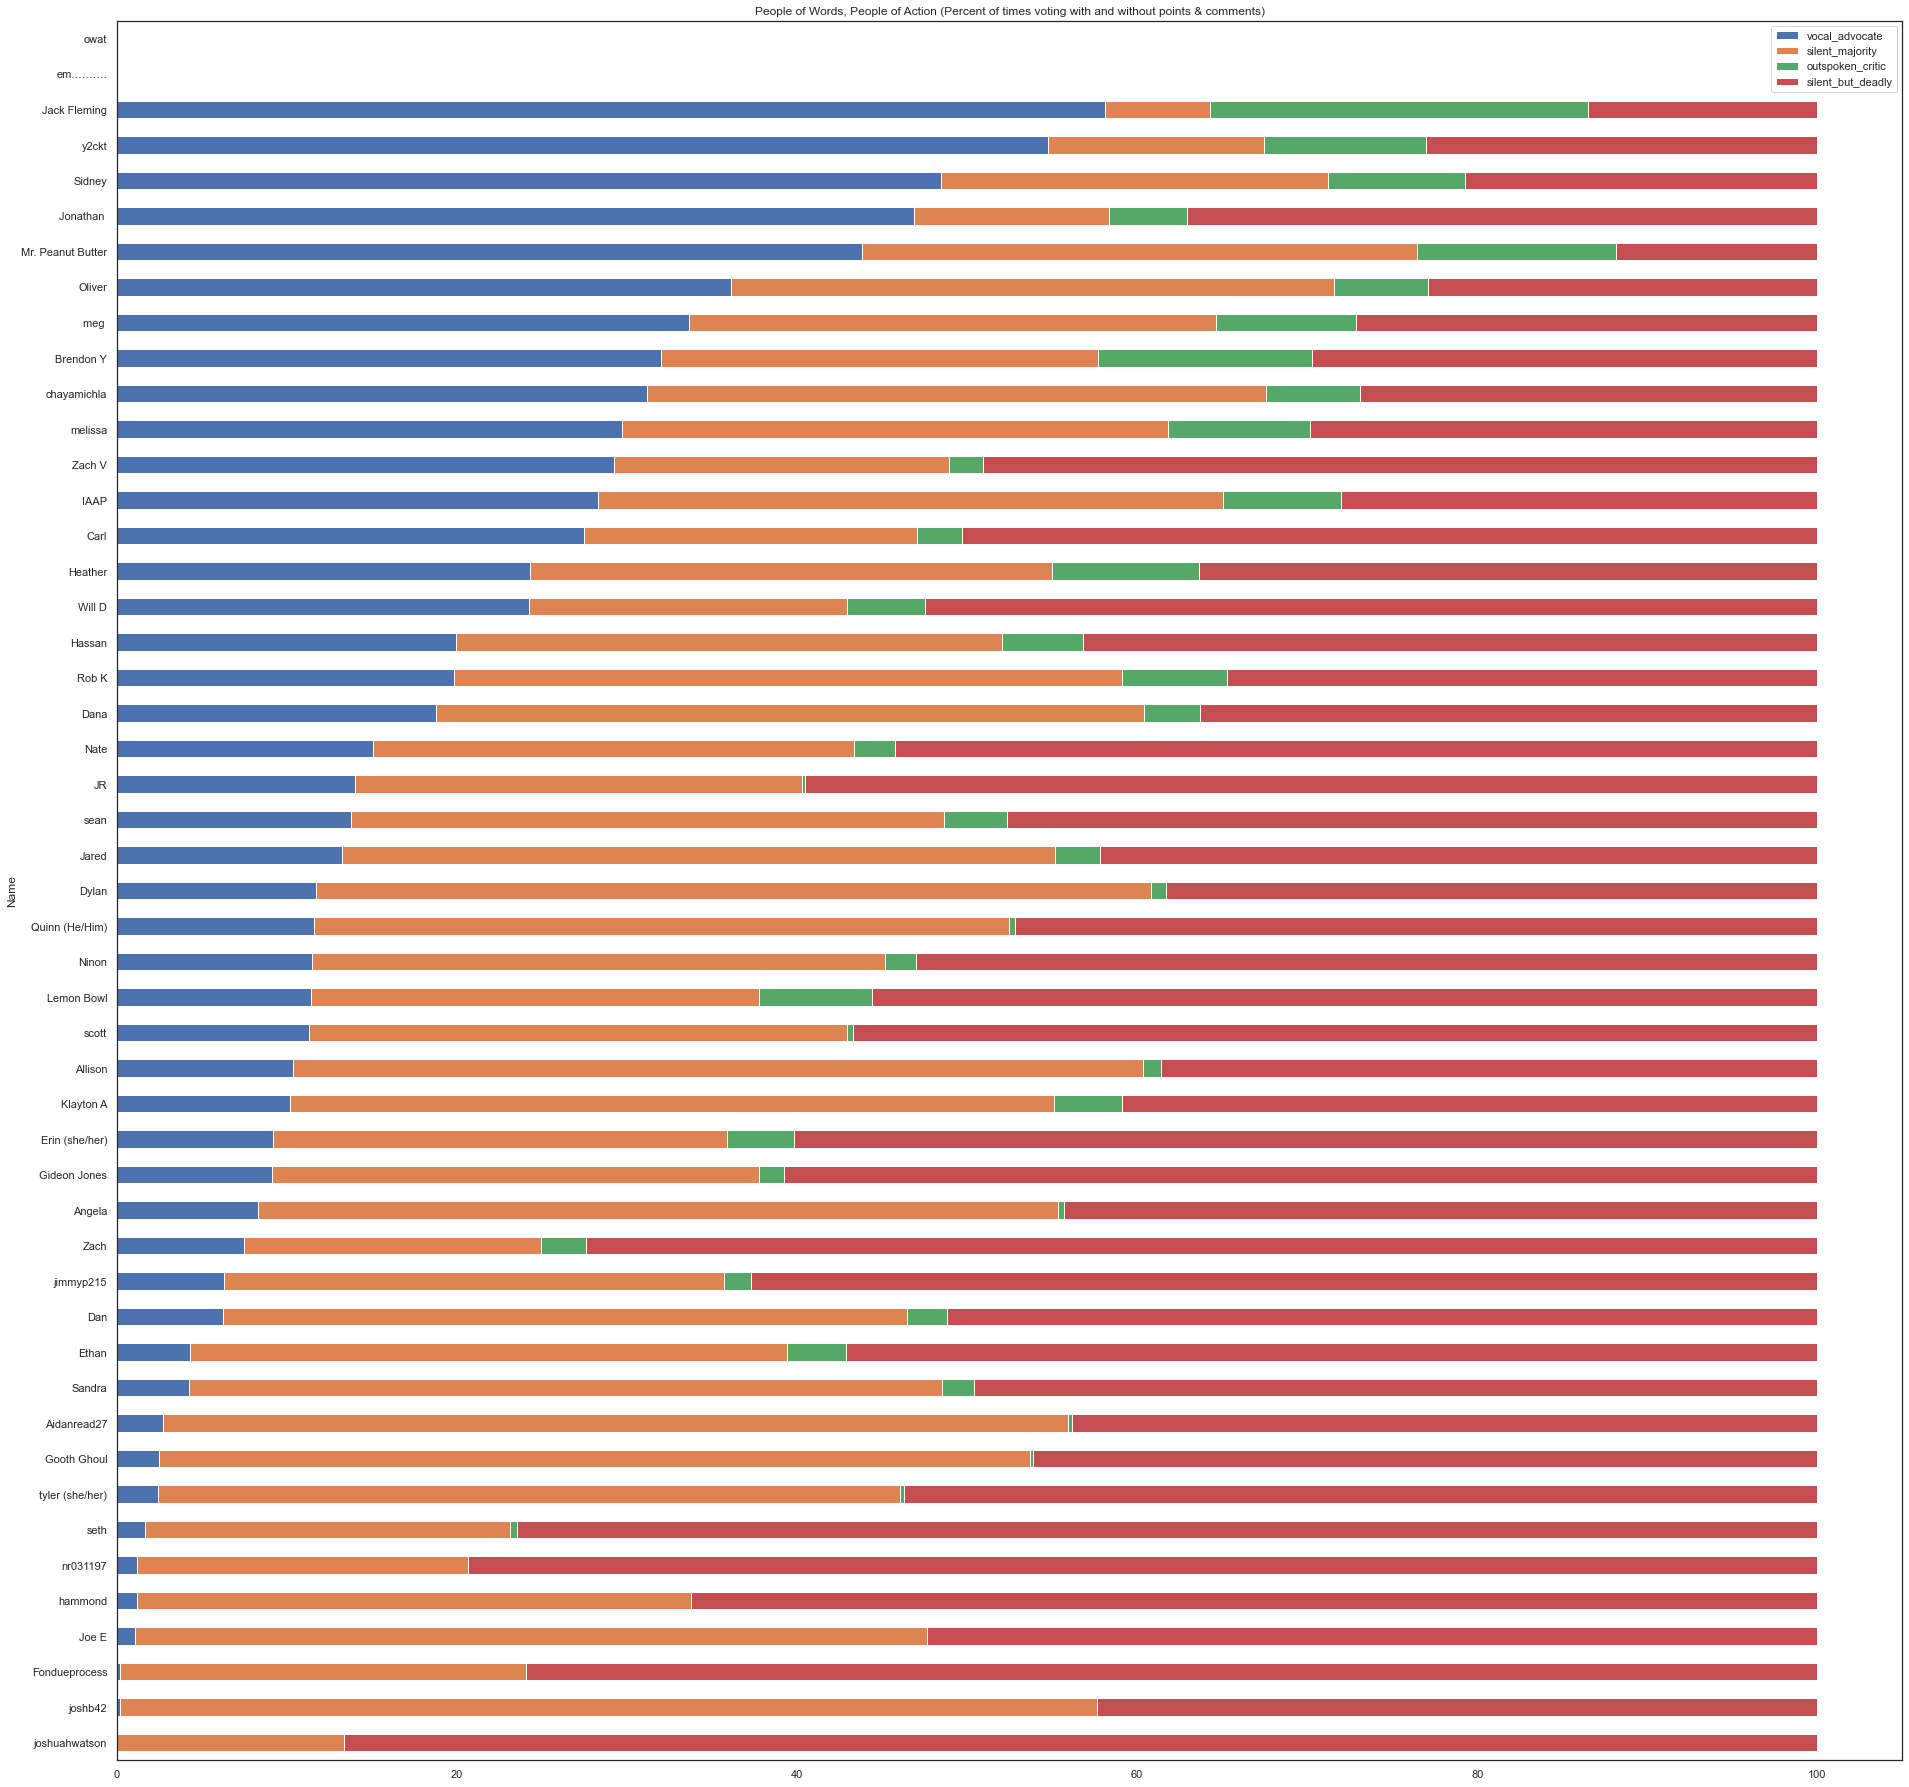

In [66]:
ax = competitor_engagement.plot.barh(x='Name', y=cols, stacked=True)

plt.title('People of Words, People of Action (Percent of times voting with and without points & comments)')
plt.gcf().set_size_inches(32, 32)

In [67]:
#maybe something here around % with points, and % with comments
#then do a quick clustering based on those two attributes to find voters with like behaviors, 
#absent their actual voting interests
percent_votes_comments = competitor_engagement
percent_votes_comments['Percent_positive']=percent_votes_comments['silent_majority']+percent_votes_comments['vocal_advocate']
percent_votes_comments['Percent_comments']=percent_votes_comments['outspoken_critic']+percent_votes_comments['vocal_advocate']

del percent_votes_comments['vocal_advocate']
del percent_votes_comments['silent_majority']
del percent_votes_comments['outspoken_critic']
del percent_votes_comments['silent_but_deadly']

percent_votes_comments.head()

,ID,Name,Percent_positive,Percent_comments
34,b289f6bd176a46e688e791937178a1c7,joshuahwatson,13.333333,0.000000
36,50bcd53a0bf84421a05d12190c08c895,joshb42,57.649254,0.186567
4,ac8a680b7955442a80c999deb6aab714,Fondueprocess,24.048096,0.200401
30,fe88b3f0df524756b638fe8ea42499e8,Joe E,47.643979,1.047120
3,2a1b637e09834879baf13d6cc3459270,hammond,33.777038,1.164725


In [68]:
percent_votes_comments = percent_votes_comments.head(percent_votes_comments.shape[0] -1)

In [69]:
percent_votes_comments = percent_votes_comments.fillna(0)
percent_votes_comments = percent_votes_comments.astype({"Percent_positive":'int', "Percent_comments":'int'}) 

In [70]:
each_participants_points = points_for.groupby(['Name_submitter']).sum()
each_participants_points.rename(columns = {'Name_submitter':'Name'}, inplace = True)
each_participants_points.reset_index()
each_participants_points.head()

,Points_Assigned,total_points_cast,percent_share
Name_submitter,,,
Aidanread27,868,32590,119.399435
Allison,1055,32715,141.208109
Angela,587,31770,82.496144
Brendon Y,744,32960,100.082561
Carl,717,32835,98.030148


In [71]:
scatterplot_dataframe1 = pd.merge(percent_votes_comments, each_participants_points[['Points_Assigned']], left_on ='Name', right_on='Name_submitter')

In [72]:
scatterplot_dataframe1.head()

,ID,Name,Percent_positive,Percent_comments,Points_Assigned
0,b289f6bd176a46e688e791937178a1c7,joshuahwatson,13,0,93
1,50bcd53a0bf84421a05d12190c08c895,joshb42,57,0,626
2,ac8a680b7955442a80c999deb6aab714,Fondueprocess,24,0,410
3,fe88b3f0df524756b638fe8ea42499e8,Joe E,47,1,844
4,2a1b637e09834879baf13d6cc3459270,hammond,33,1,637


In [73]:
from sklearn.cluster import KMeans

In [74]:
#vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).count()
rounds_participated = submissions.groupby(['Name']).count()
rounds_participated.rename(columns={'Spotify URI': 'Num_rounds'}, inplace=True)
del rounds_participated['Submitter ID']
del rounds_participated['Created']
del rounds_participated['Comment']
del rounds_participated['Round ID']
del rounds_participated['ID']

scatterplot_dataframe1 = scatterplot_dataframe1.merge(rounds_participated[['Num_rounds']], on ='Name')
scatterplot_dataframe1['avg_per_round']=scatterplot_dataframe1['Points_Assigned']/scatterplot_dataframe1['Num_rounds']
scatterplot_dataframe1.head()

,ID,Name,Percent_positive,Percent_comments,Points_Assigned,Num_rounds,avg_per_round
0,b289f6bd176a46e688e791937178a1c7,joshuahwatson,13,0,93,2,46.500000
1,50bcd53a0bf84421a05d12190c08c895,joshb42,57,0,626,13,48.153846
2,ac8a680b7955442a80c999deb6aab714,Fondueprocess,24,0,410,14,29.285714
3,fe88b3f0df524756b638fe8ea42499e8,Joe E,47,1,844,15,56.266667
4,2a1b637e09834879baf13d6cc3459270,hammond,33,1,637,17,37.470588


In [75]:
positive_mean = scatterplot_dataframe1['Percent_positive'].mean()
comments_mean = scatterplot_dataframe1['Percent_comments'].mean()

In [76]:
# K-Means clustering to find 2 clusters based on comments and votes
kmeans = KMeans(n_clusters=4, random_state=0).fit(scatterplot_dataframe1[["Percent_positive", "Percent_comments"]])


# See the cluster label for each data point / Group label of each voter
kmean_labels = kmeans.labels_
kmeans.labels_



array([1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2], dtype=int32)

In [77]:
# Identifying the (final) cluster centroids
kmeans.cluster_centers_

array([[57.53846154, 32.92307692],
       [29.09090909,  6.27272727],
       [67.2       , 61.2       ],
       [50.38888889,  9.11111111]])

In [78]:
labels = scatterplot_dataframe1['Name'].to_numpy()
labels

array(['joshuahwatson', 'joshb42', 'Fondueprocess', 'Joe E', 'hammond',
       'nr031197', 'seth', 'tyler (she/her)', 'Gooth Ghoul',
       'Aidanread27', 'Sandra', 'Ethan', 'Dan', 'jimmyp215', 'Zach',
       'Angela', 'Gideon Jones', 'Erin (she/her)', 'Klayton A', 'Allison',
       'scott', 'Lemon Bowl', 'Ninon', 'Quinn (He/Him)', 'Dylan', 'Jared',
       'sean', 'JR', 'Nate', 'Dana', 'Rob K', 'Hassan', 'Will D',
       'Heather', 'Carl', 'IAAP', 'Zach V', 'melissa', 'chayamichla',
       'Brendon Y', 'meg ', 'Oliver', 'Mr. Peanut Butter', 'Jonathan ',
       'Sidney', 'y2ckt', 'Jack Fleming'], dtype=object)

In [79]:
import matplotlib.pyplot as plt

In [80]:
from mpld3 import plugins

In [81]:
import mplcursors

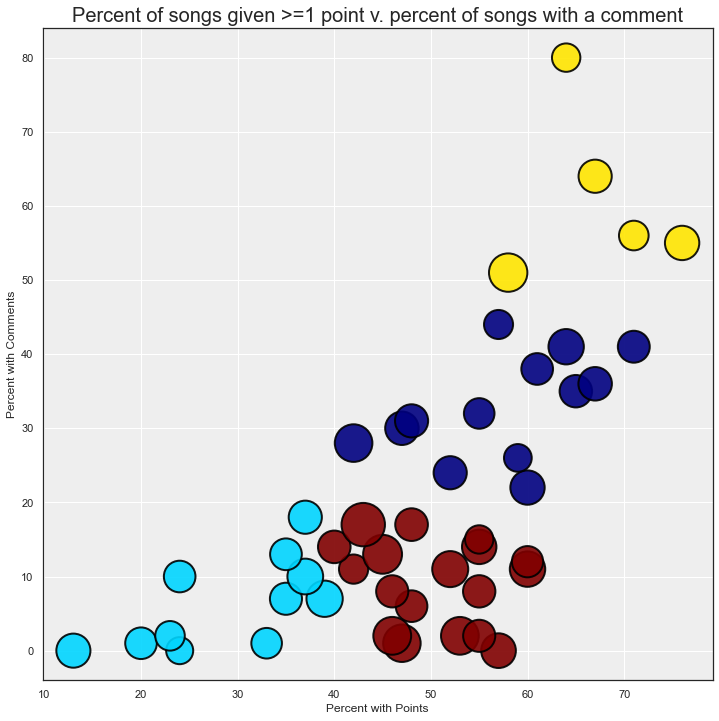

In [82]:
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))
N = len(competitors)-1

scatter = ax.scatter(x=scatterplot_dataframe1.Percent_positive,
                     y=scatterplot_dataframe1.Percent_comments,
                     s=25*scatterplot_dataframe1.avg_per_round,
                     c=kmean_labels,
                     alpha=0.9,
                     cmap=plt.cm.jet,
                     linewidths=2,
                     edgecolors='black')
ax.grid(color='white', linestyle='solid')

ax.set_title("Percent of songs given >=1 point v. percent of songs with a comment", size=20)

#cursor = mplcursors.cursor(scatter, hover=True)
#@cursor.connect("add")
#def on_add(sel):
    #sel.annotation.set(text=scatterplot_dataframe1['Name'])

mplcursors.cursor().connect(
    "add", lambda sel: sel.annotation.set_text(scatterplot_dataframe1["Name"][sel.index]))    

    
plt.gcf().set_size_inches(12, 12)
plt.xlabel('Percent with Points')
plt.ylabel('Percent with Comments')

#mpld3.display()
plt.show()

In [83]:
from mpld3 import plugins

In [84]:
percent_votes_comments.head()

,ID,Name,Percent_positive,Percent_comments
34,b289f6bd176a46e688e791937178a1c7,joshuahwatson,13,0
36,50bcd53a0bf84421a05d12190c08c895,joshb42,57,0
4,ac8a680b7955442a80c999deb6aab714,Fondueprocess,24,0
30,fe88b3f0df524756b638fe8ea42499e8,Joe E,47,1
3,2a1b637e09834879baf13d6cc3459270,hammond,33,1


In [85]:
points_for.head()

,Name_voter,Name_submitter,Points_Assigned,total_points_cast,percent_share
0,Aidanread27,Allison,28,870,3.218391
1,Aidanread27,Angela,22,870,2.528736
2,Aidanread27,Brendon Y,23,870,2.643678
3,Aidanread27,Carl,21,870,2.413793
4,Aidanread27,Dan,27,870,3.103448


In [86]:
competitor_PARS = competitors
competitor_PARS.head()

,ID,Name,vocal_advocate,silent_majority,outspoken_critic,silent_but_deadly
0,f99a5821c49d4a8eaa40dbc457beda3c,Jack Fleming,58.104396,6.181319,22.252747,13.461538
1,e595e8971f0d4500b512f788f52e60da,Quinn (He/Him),11.568123,40.874036,0.385604,47.172237
2,e2c317228ea34373a515e66d3a20c482,y2ckt,54.769737,12.664474,9.539474,23.026316
3,2a1b637e09834879baf13d6cc3459270,hammond,1.164725,32.612313,0.000000,66.222962
4,ac8a680b7955442a80c999deb6aab714,Fondueprocess,0.200401,23.847695,0.000000,75.951904


In [87]:
# points above replacement submission
    #PARS
    #Look at the median submission for each round
    #subtract that from your submission each round
    #sum per voter
    
#need to do both:
    #median submission per round
    #which competitor was in each round

In [88]:
round_song_sum = round_song_sum.merge(num_per_round, how='left', on=['Round_ID'])


round_song_sum.reset_index()

#num_per_round now shows the number of songs submitted in each round. 
#now, we merge that with round_song_sum so we can identify how many to .nlargest()


####n.largest()????

round_song_sum.head()

#here we gotta figure out how to essentially tag each song submitted with position in the submissions per that round

# then, see who what percent of each person's votes went to a top 3 song and a bottom 3 song 
# by incorporating the votes_and_submission table

#round_song_sum = round_song_sum.groupby(['Round_ID', 'Name_submitter']).nlargest()
#round_song_sum.head()

,Round_ID,Points_Received,count_songs,Jack Fleming,Quinn (He/Him),y2ckt,hammond,Fondueprocess,Heather,Oliver,...,seth,Jared,Dylan,Hassan,sean,Carl,Angela,jimmyp215,owat,Sidney
0,09502eae8e58411fbe1f640e2d5d837b,32,40,35,16,28,12,0,25,28,...,0,25,24,24,0,19,0,22,0,38
1,09502eae8e58411fbe1f640e2d5d837b,40,40,35,16,28,12,0,25,28,...,0,25,24,24,0,19,0,22,0,38
2,09502eae8e58411fbe1f640e2d5d837b,31,40,35,16,28,12,0,25,28,...,0,25,24,24,0,19,0,22,0,38
3,09502eae8e58411fbe1f640e2d5d837b,59,40,35,16,28,12,0,25,28,...,0,25,24,24,0,19,0,22,0,38
4,09502eae8e58411fbe1f640e2d5d837b,20,40,35,16,28,12,0,25,28,...,0,25,24,24,0,19,0,22,0,38
